In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gdown
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition   import PCA
from sklearn.pipeline        import make_pipeline
from sklearn.cluster         import KMeans
from sklearn.ensemble        import IsolationForest, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LogisticRegression
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.svm             import LinearSVC
from sklearn.tree            import DecisionTreeClassifier
from sklearn                 import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.metrics         import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    ConfusionMatrixDisplay
)
from statsmodels.tsa.stattools     import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import math
import time
import random
import datetime
%matplotlib inline
warnings.filterwarnings("ignore")

## 2. Load Raw Sensor Data

Load the raw sensor data from the CSV file into a DataFrame, drop the redundant index column (if present), and display the first few rows to inspect the data.


In [2]:
path = 'sensor.csv'
df = pd.read_csv(path)
df.head()

Unnamed: 0            timestamp  sensor_00  sensor_01  sensor_02  \
0           0  2018-04-01 00:00:00   2.465394   47.09201    53.2118   
1           1  2018-04-01 00:01:00   2.465394   47.09201    53.2118   
2           2  2018-04-01 00:02:00   2.444734   47.35243    53.2118   
3           3  2018-04-01 00:03:00   2.460474   47.09201    53.1684   
4           4  2018-04-01 00:04:00   2.445718   47.13541    53.2118   

   sensor_03  sensor_04  sensor_05  sensor_06  sensor_07  ...  sensor_43  \
0  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
1  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
2  46.397570   638.8889   73.54598   13.32465   16.03733  ...   41.66666   
3  46.397568   628.1250   76.98898   13.31742   16.24711  ...   40.88541   
4  46.397568   636.4583   76.58897   13.35359   16.21094  ...   41.40625   

   sensor_44  sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  \
0  39.641200   65.68287   50.92593  38.194440   157.9861   67.70834   
1  39.641200   65.68287   50.92593  38.194440   157.9861   67.70834   
2  39.351852   65.39352   51.21528  38.194443   155.9606   67.12963   
3  39.062500   64.81481   51.21528  38.194440   155.9606   66.84028   
4  38.773150   65.10416   51.79398  38.773150   158.2755   66.55093   

   sensor_50  sensor_51  machine_status  
0   243.0556   201.3889          NORMAL  
1   243.0556   201.3889          NORMAL  
2   241.3194   203.7037          NORMAL  
3   240.4514   203.1250          NORMAL  
4   242.1875   201.3889          NORMAL  

[5 rows x 55 columns]

In [3]:
df.shape

(220320, 55)

In [4]:
df.isna().sum()

Unnamed: 0             0
timestamp              0
sensor_00          10208
sensor_01            369
sensor_02             19
sensor_03             19
sensor_04             19
sensor_05             19
sensor_06           4798
sensor_07           5451
sensor_08           5107
sensor_09           4595
sensor_10             19
sensor_11             19
sensor_12             19
sensor_13             19
sensor_14             21
sensor_15         220320
sensor_16             31
sensor_17             46
sensor_18             46
sensor_19             16
sensor_20             16
sensor_21             16
sensor_22             41
sensor_23             16
sensor_24             16
sensor_25             36
sensor_26             20
sensor_27             16
sensor_28             16
sensor_29             72
sensor_30            261
sensor_31             16
sensor_32             68
sensor_33             16
sensor_34             16
sensor_35             16
sensor_36             16
sensor_37             16


## 3. Inspect DataFrame Structure
Get a concise summary of the DataFrame’s columns, dtypes, and non-null counts.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

## 4. Data Cleaning: Remove Duplicates & Unused Column
Drop duplicate rows and remove the sensor_15 column (entirely NaN).

In [6]:
df = df.drop_duplicates()

In [7]:
df.drop(columns=['sensor_15','sensor_50','Unnamed: 0'],axis=1,inplace=True)

## 5. Missing Values Analysis
Define a helper function to compute the percentage of missing values per column and show the top 10.

In [8]:
def calc_percent_NAs(df):
    """Return DataFrame of columns with percent missing > 0."""
    nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False) / len(df),
                        columns=['percent'])
    return nans[nans['percent'] > 0]

calc_percent_NAs(df).head(10)

percent
sensor_51  0.069821
sensor_00  0.046333
sensor_07  0.024741
sensor_08  0.023180
sensor_06  0.021777
sensor_09  0.020856
sensor_01  0.001675
sensor_30  0.001185
sensor_29  0.000327
sensor_32  0.000309

## 6. Fill Missing Values
Impute missing values in the top sensors using their mean.

In [9]:
from tqdm import tqdm

exclude_cols = ["machine_status", "timestamp"]

for col in tqdm(df.columns):
    if col not in exclude_cols:
        df[col] = df[col].fillna(df[col].mean())


100%|███████████████████████████████████████████| 52/52 [00:00<00:00, 80.89it/s]


In [10]:
df.isna().sum()

timestamp         0
sensor_00         0
sensor_01         0
sensor_02         0
sensor_03         0
sensor_04         0
sensor_05         0
sensor_06         0
sensor_07         0
sensor_08         0
sensor_09         0
sensor_10         0
sensor_11         0
sensor_12         0
sensor_13         0
sensor_14         0
sensor_16         0
sensor_17         0
sensor_18         0
sensor_19         0
sensor_20         0
sensor_21         0
sensor_22         0
sensor_23         0
sensor_24         0
sensor_25         0
sensor_26         0
sensor_27         0
sensor_28         0
sensor_29         0
sensor_30         0
sensor_31         0
sensor_32         0
sensor_33         0
sensor_34         0
sensor_35         0
sensor_36         0
sensor_37         0
sensor_38         0
sensor_39         0
sensor_40         0
sensor_41         0
sensor_42         0
sensor_43         0
sensor_44         0
sensor_45         0
sensor_46         0
sensor_47         0
sensor_48         0
sensor_49         0


## 7. Verify Missing Values Imputation
Re-run the missing-values function to confirm no remaining gaps in those columns.

In [11]:
calc_percent_NAs(df).head(10)

Empty DataFrame
Columns: [percent]
Index: []

## 8. Timestamp Conversion & Indexing
Convert the timestamp column to datetime, drop the original, and set as index.

In [12]:
df['date'] = pd.to_datetime(df['timestamp'])
del df['timestamp']
df = df.set_index('date')
df.head()

sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  \
date                                                                         
2018-04-01 00:00:00   2.465394   47.09201    53.2118  46.310760   634.3750   
2018-04-01 00:01:00   2.465394   47.09201    53.2118  46.310760   634.3750   
2018-04-01 00:02:00   2.444734   47.35243    53.2118  46.397570   638.8889   
2018-04-01 00:03:00   2.460474   47.09201    53.1684  46.397568   628.1250   
2018-04-01 00:04:00   2.445718   47.13541    53.2118  46.397568   636.4583   

                     sensor_05  sensor_06  sensor_07  sensor_08  sensor_09  \
date                                                                         
2018-04-01 00:00:00   76.45975   13.41146   16.13136   15.56713   15.05353   
2018-04-01 00:01:00   76.45975   13.41146   16.13136   15.56713   15.05353   
2018-04-01 00:02:00   73.54598   13.32465   16.03733   15.61777   15.01013   
2018-04-01 00:03:00   76.98898   13.31742   16.24711   15.69734   15.08247   
2018-04-01 00:04:00   76.58897   13.35359   16.21094   15.69734   15.08247   

                     ...  sensor_42  sensor_43  sensor_44  sensor_45  \
date                 ...                                               
2018-04-01 00:00:00  ...  31.770832   41.92708  39.641200   65.68287   
2018-04-01 00:01:00  ...  31.770832   41.92708  39.641200   65.68287   
2018-04-01 00:02:00  ...  31.770830   41.66666  39.351852   65.39352   
2018-04-01 00:03:00  ...  31.510420   40.88541  39.062500   64.81481   
2018-04-01 00:04:00  ...  31.510420   41.40625  38.773150   65.10416   

                     sensor_46  sensor_47  sensor_48  sensor_49  sensor_51  \
date                                                                         
2018-04-01 00:00:00   50.92593  38.194440   157.9861   67.70834   201.3889   
2018-04-01 00:01:00   50.92593  38.194440   157.9861   67.70834   201.3889   
2018-04-01 00:02:00   51.21528  38.194443   155.9606   67.12963   203.7037   
2018-04-01 00:03:00   51.21528  38.194440   155.9606   66.84028   203.1250   
2018-04-01 00:04:00   51.79398  38.773150   158.2755   66.55093   201.3889   

                     machine_status  
date                                 
2018-04-01 00:00:00          NORMAL  
2018-04-01 00:01:00          NORMAL  
2018-04-01 00:02:00          NORMAL  
2018-04-01 00:03:00          NORMAL  
2018-04-01 00:04:00          NORMAL  

[5 rows x 51 columns]

## 9. Machine Status Distribution
Count occurrences of each machine_status to understand class balance.

In [13]:
df['machine_status'].value_counts()

machine_status
NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: count, dtype: int64

## 10. Time-Series Visualization with BROKEN Status
Overlay “BROKEN” points on each sensor time series to spot failure events.

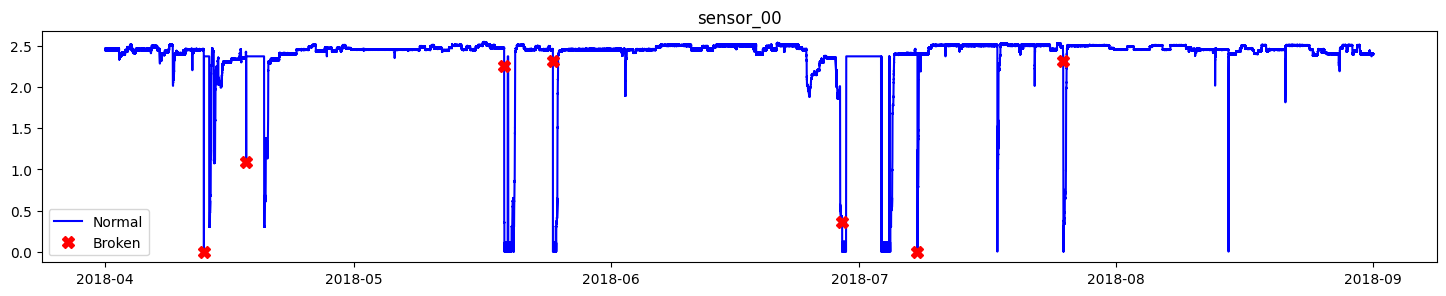

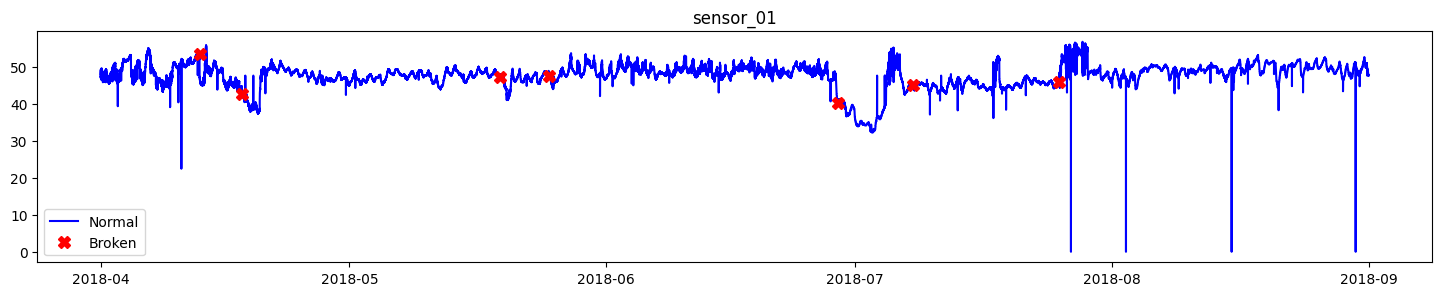

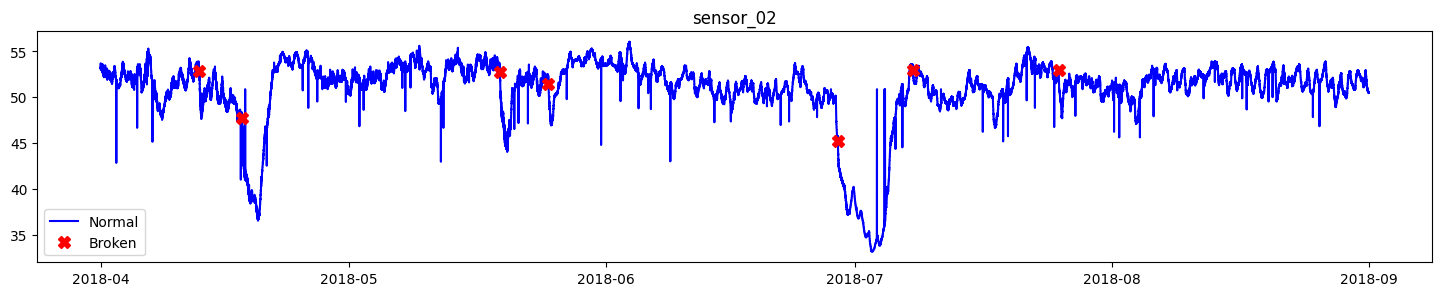

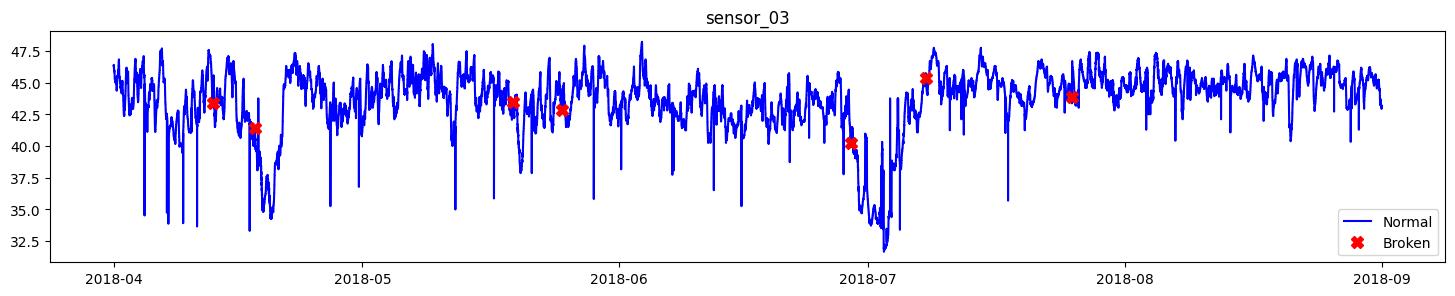

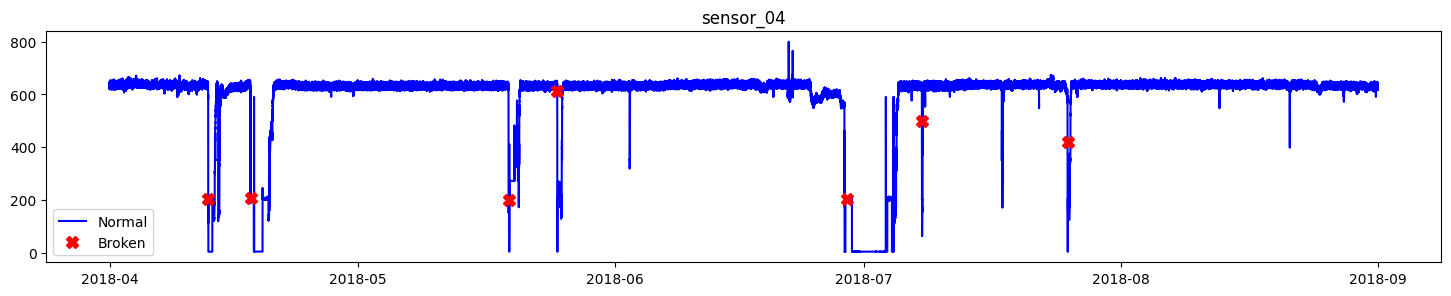

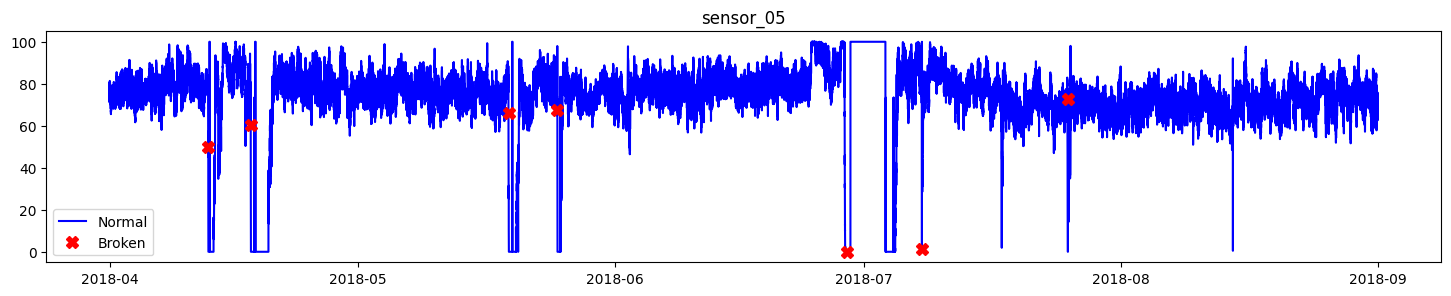

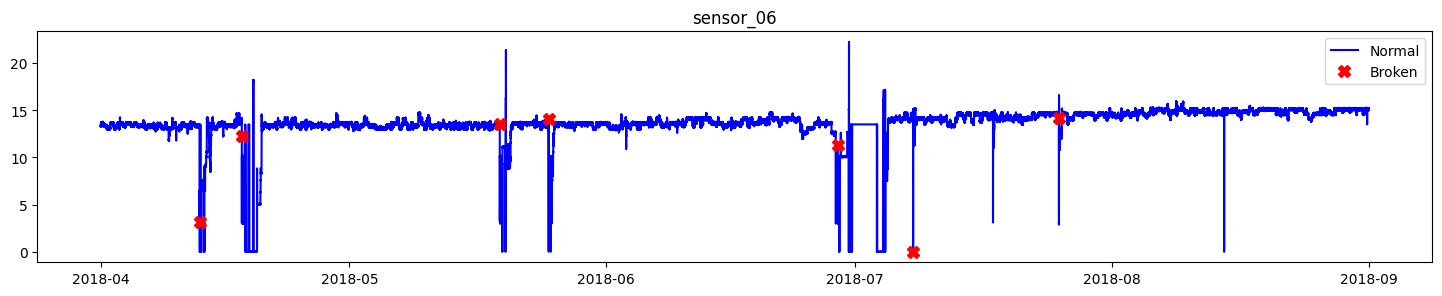

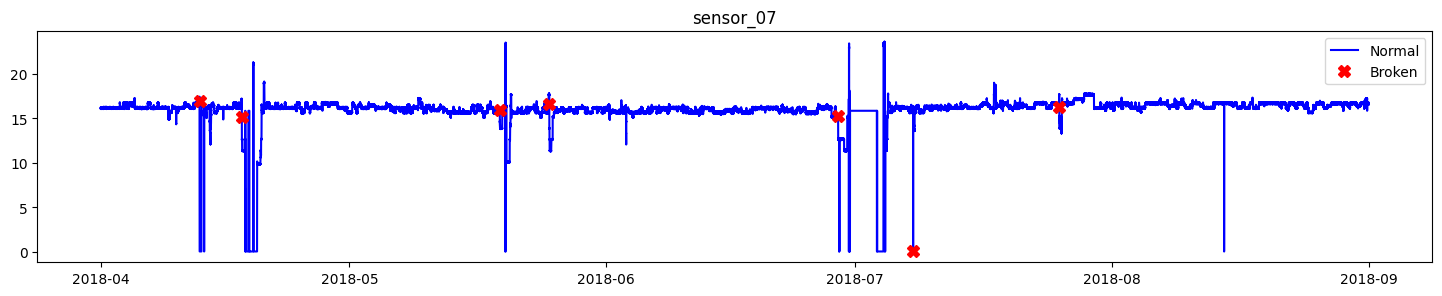

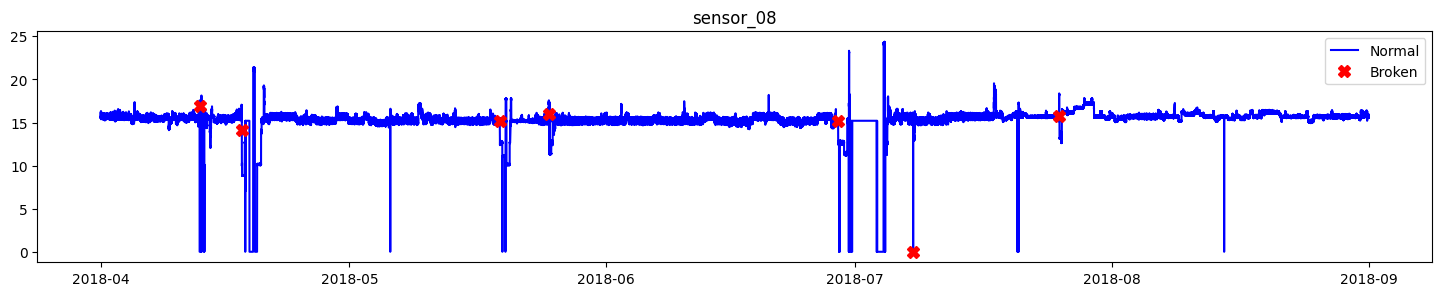

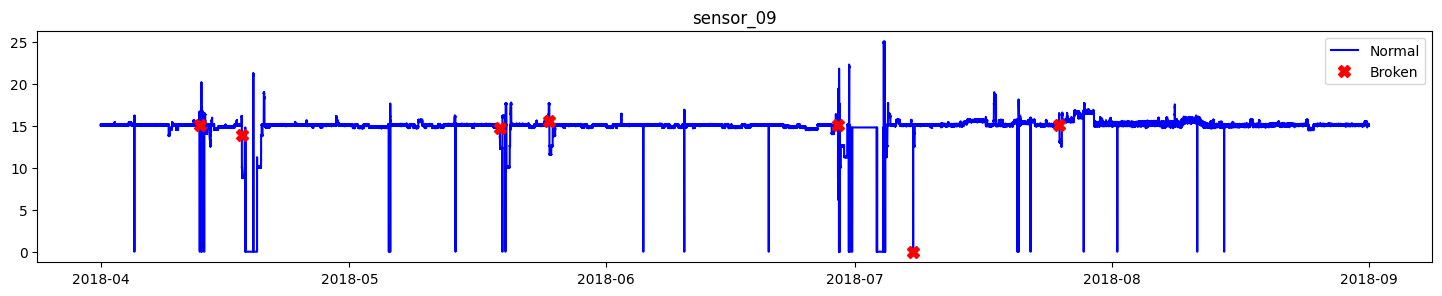

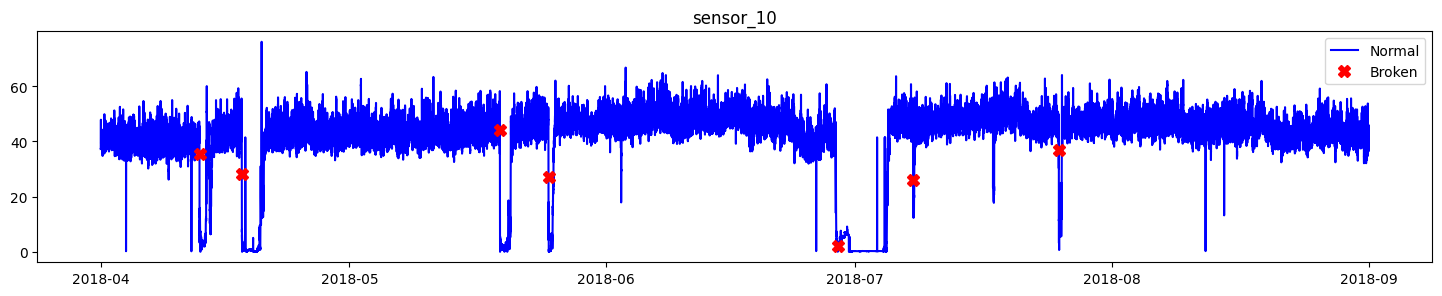

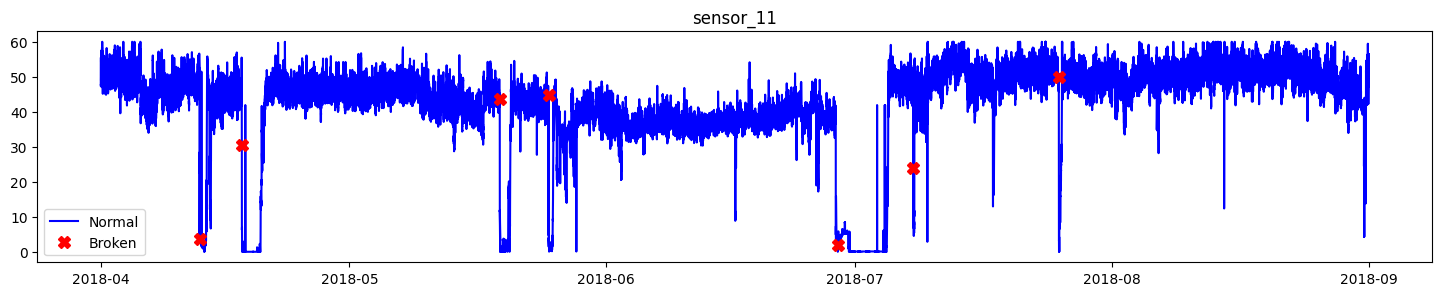

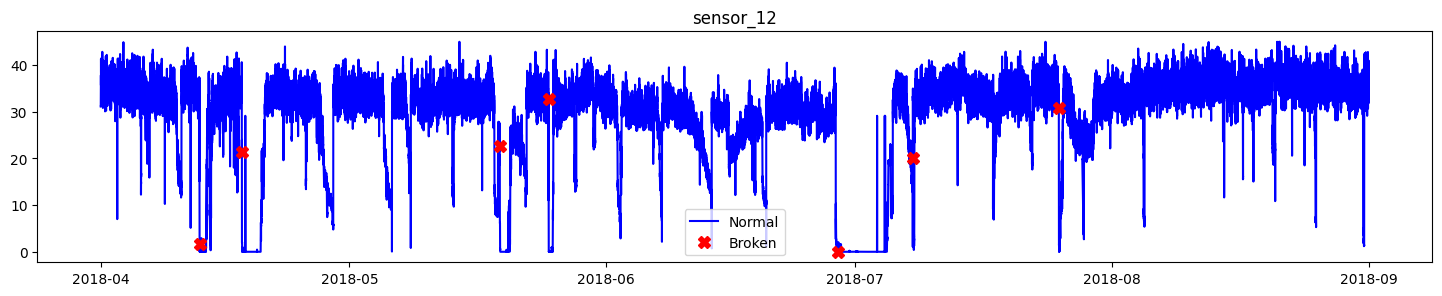

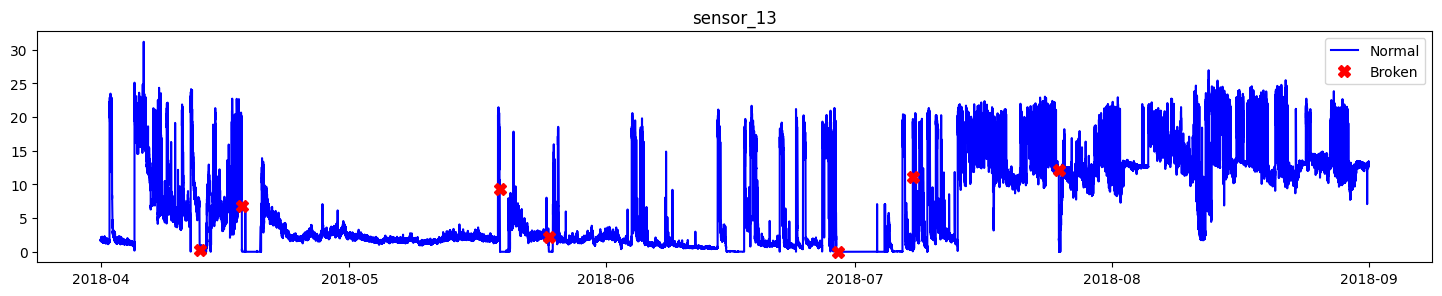

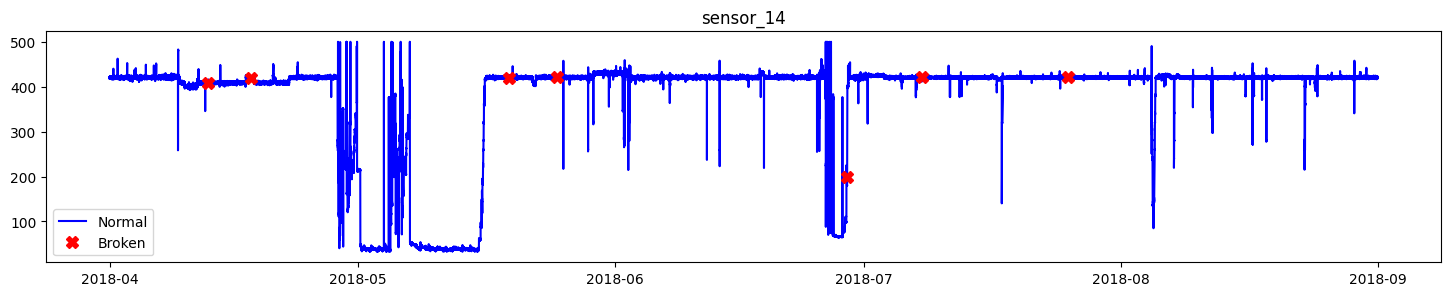

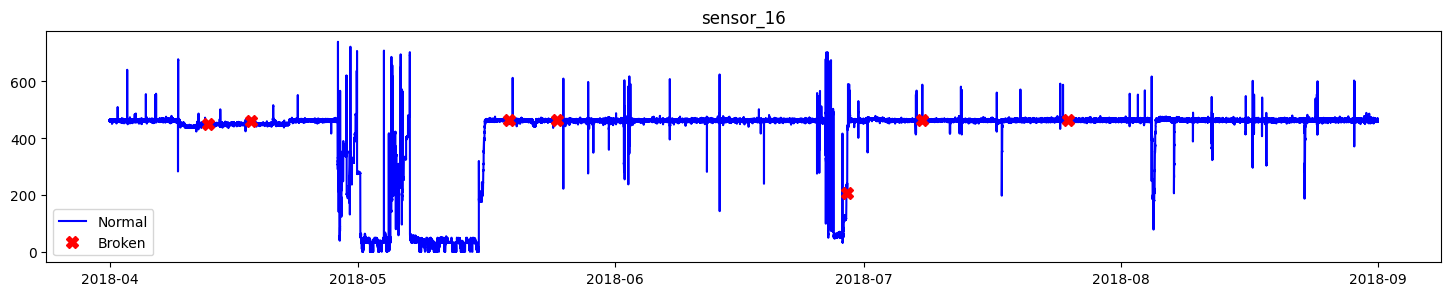

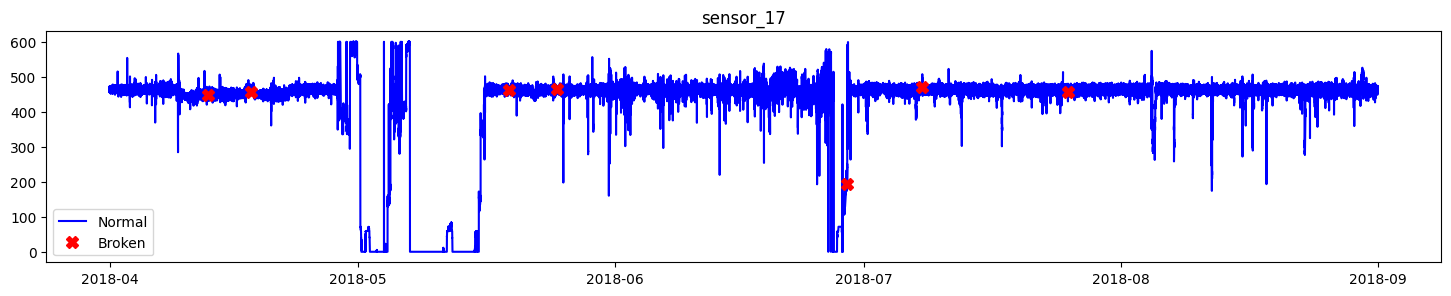

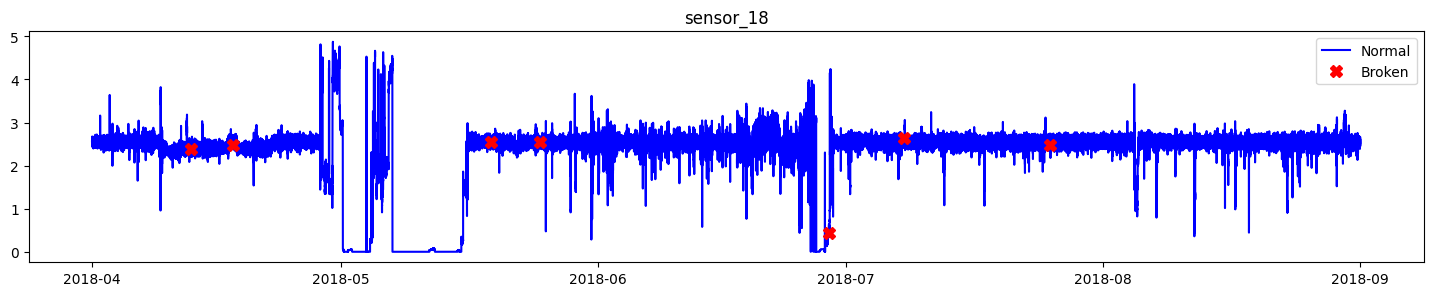

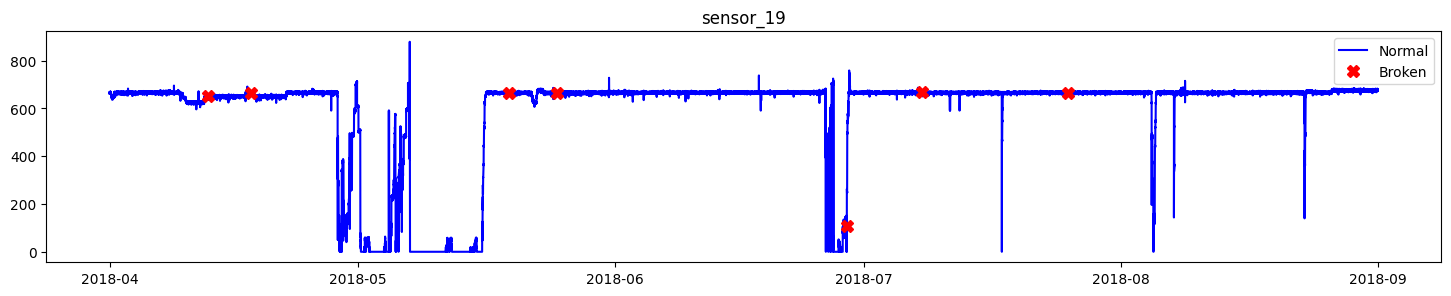

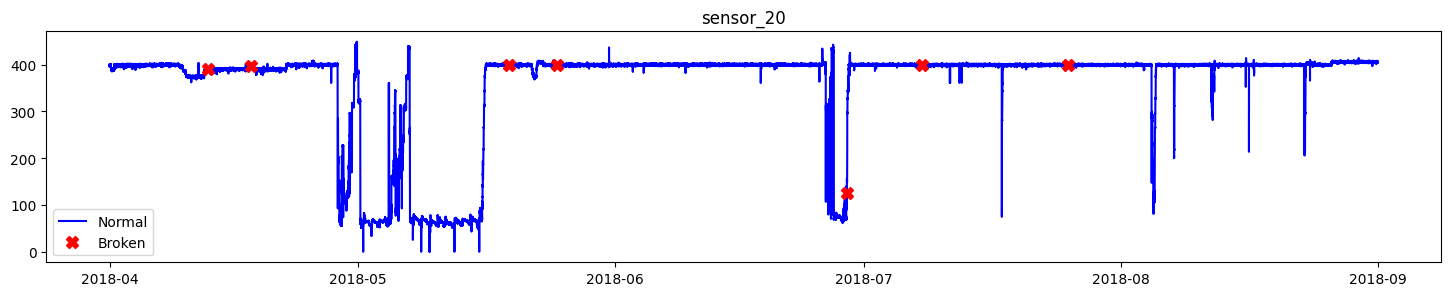

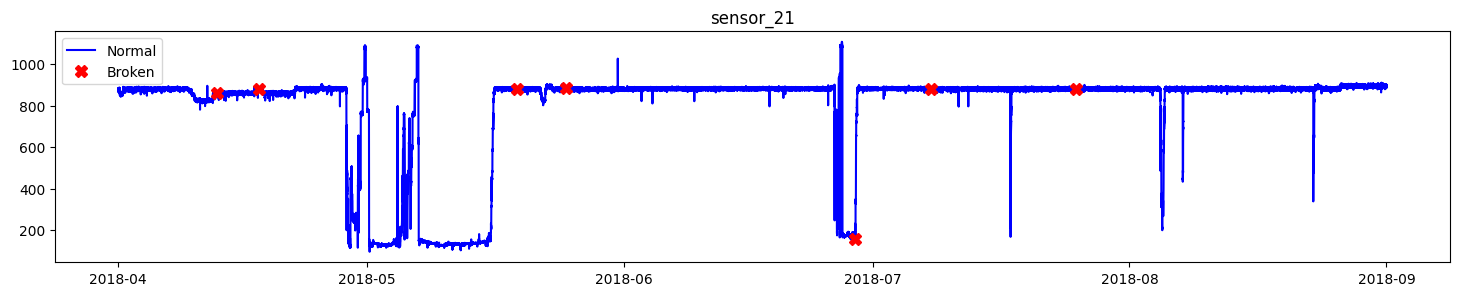

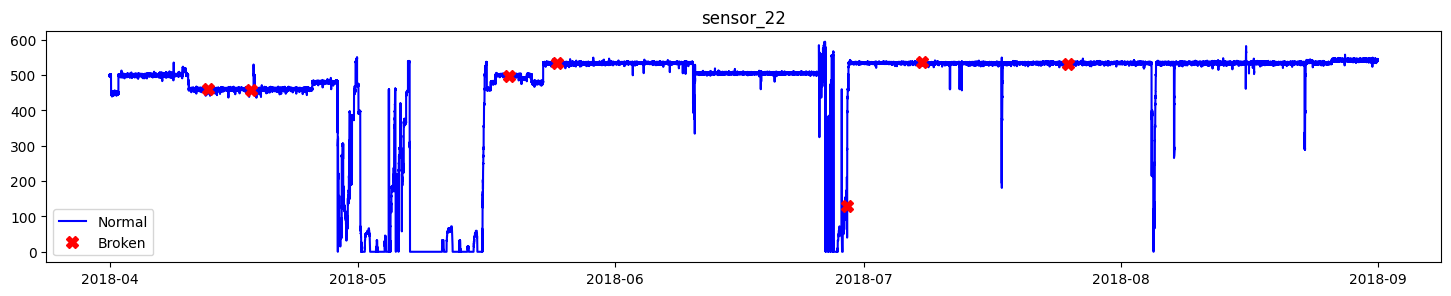

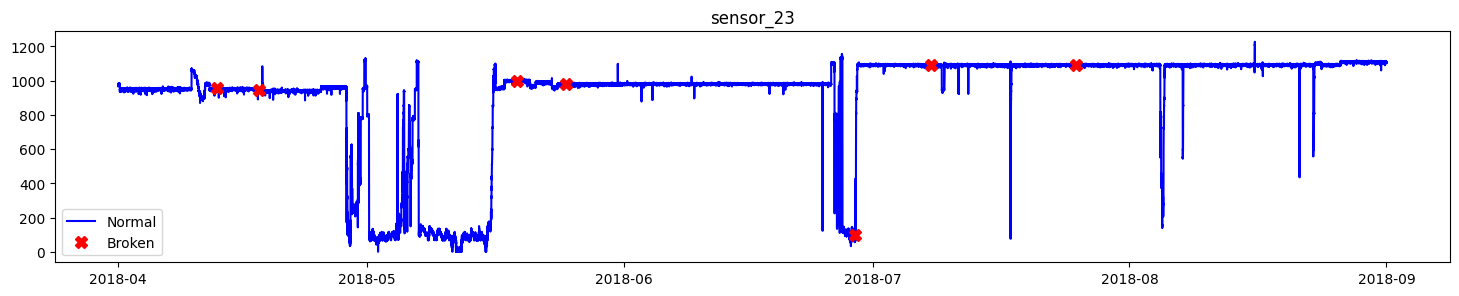

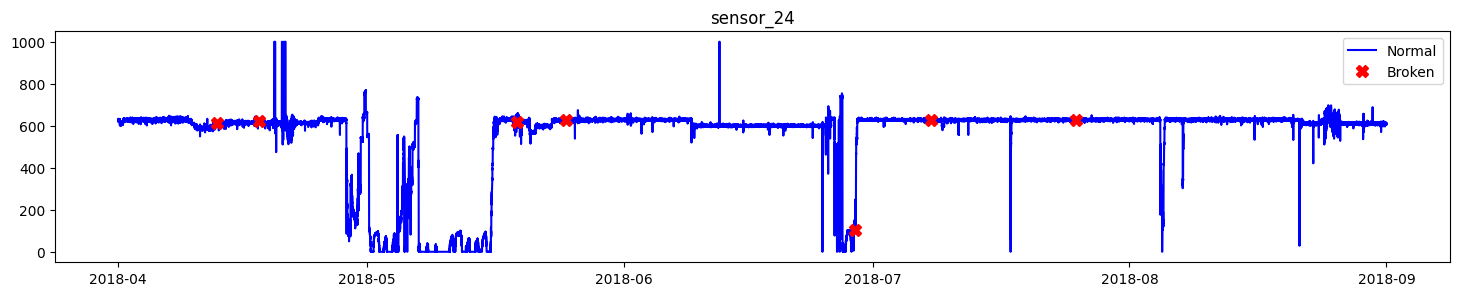

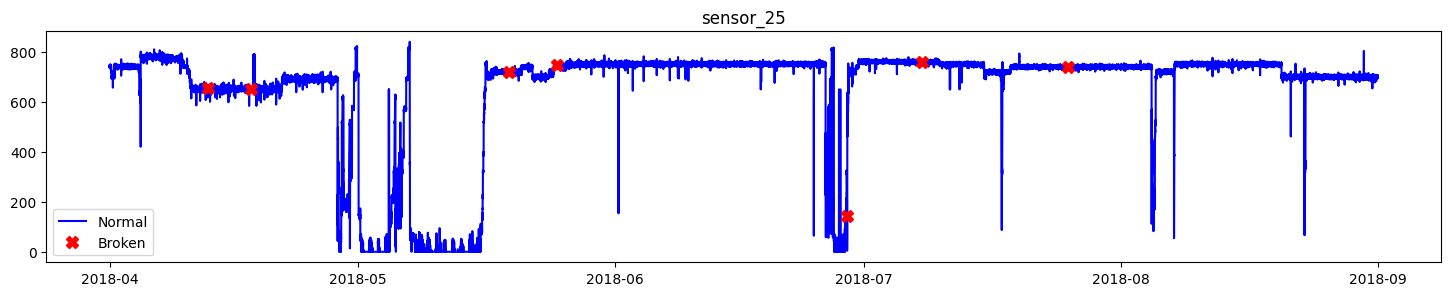

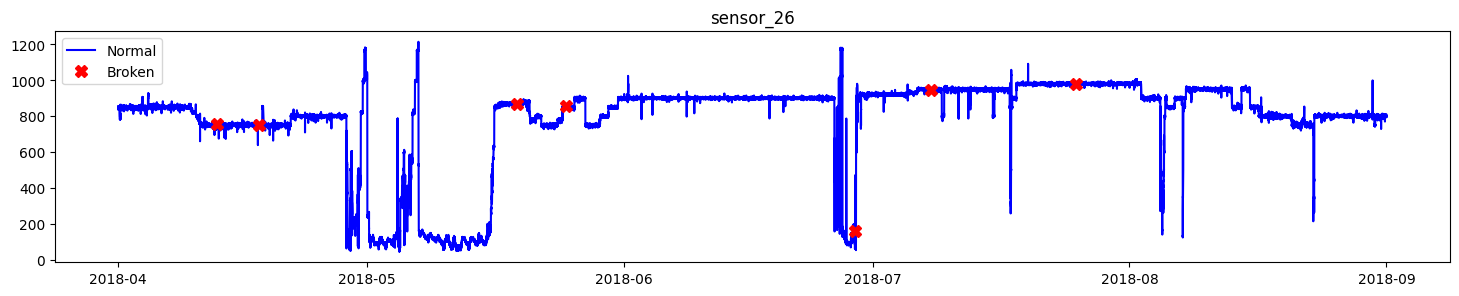

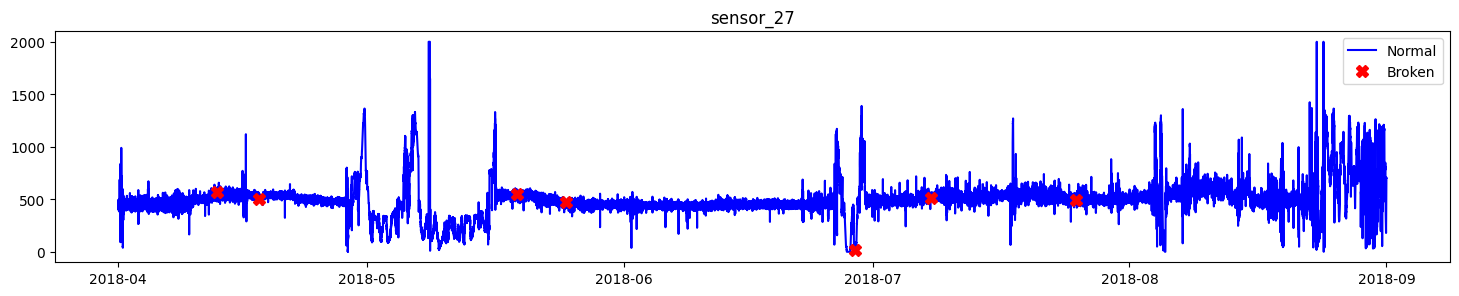

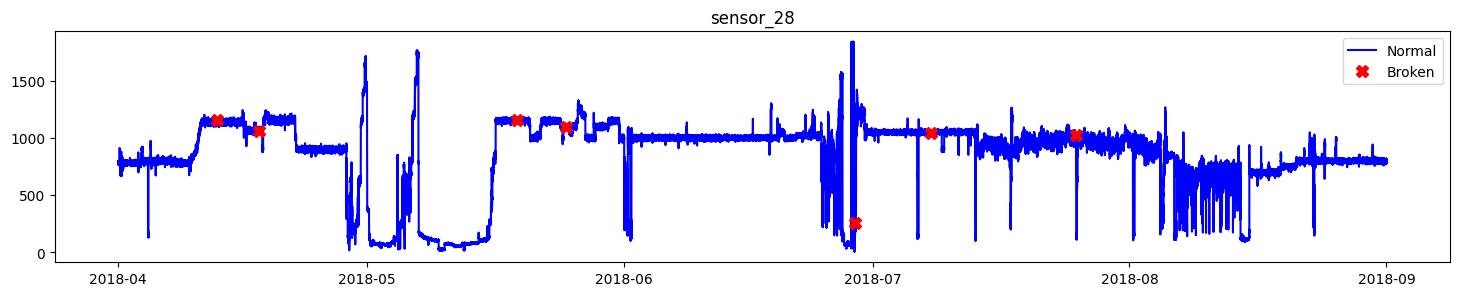

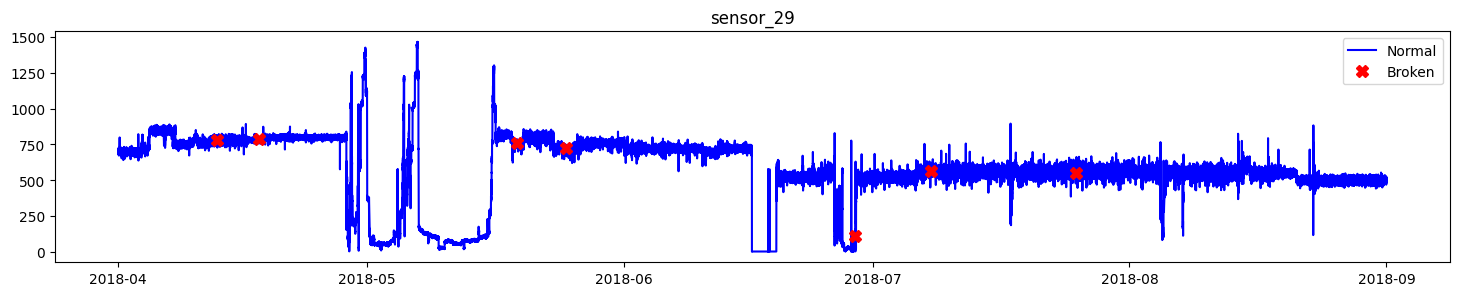

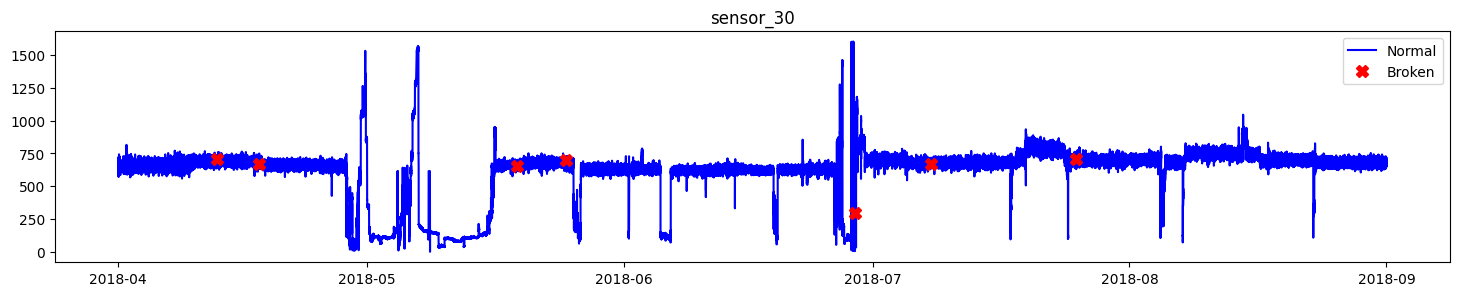

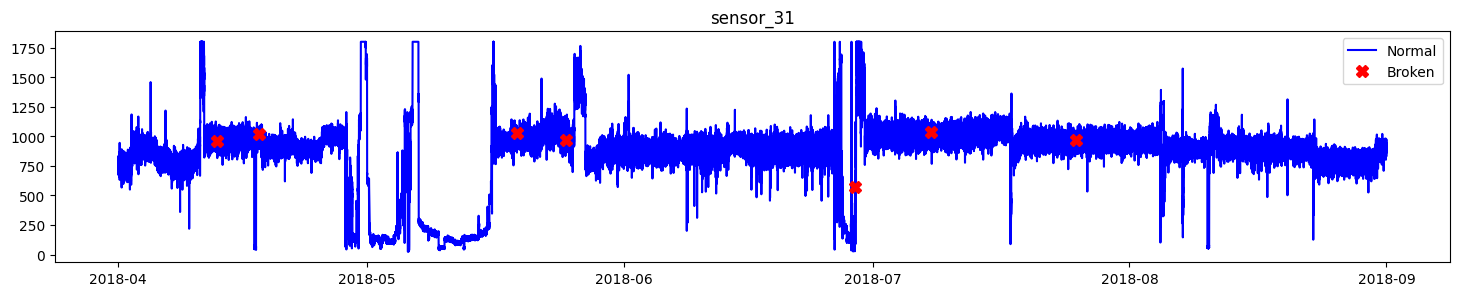

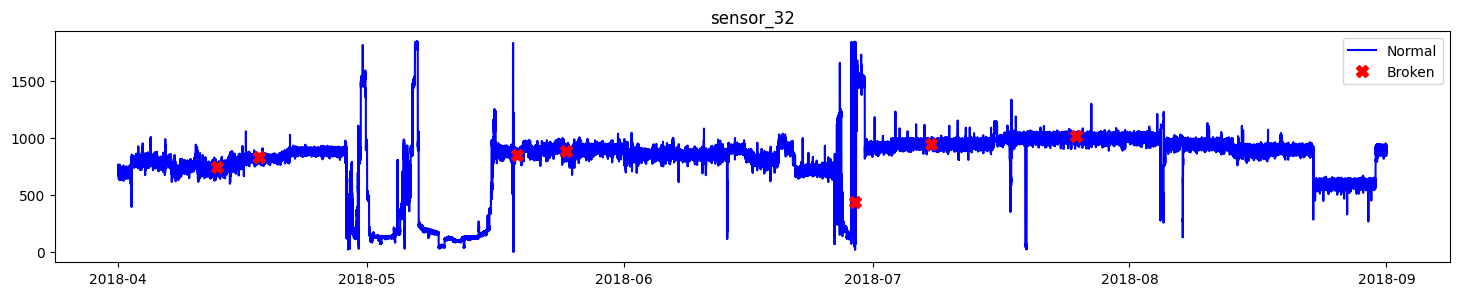

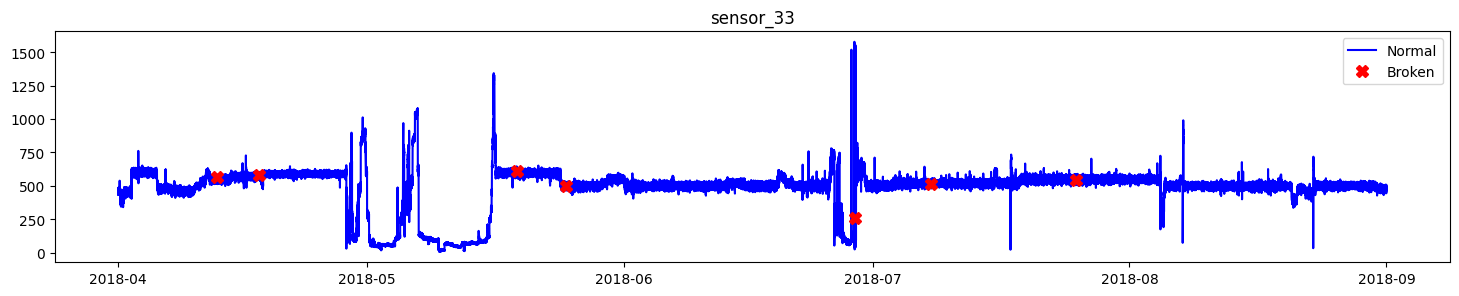

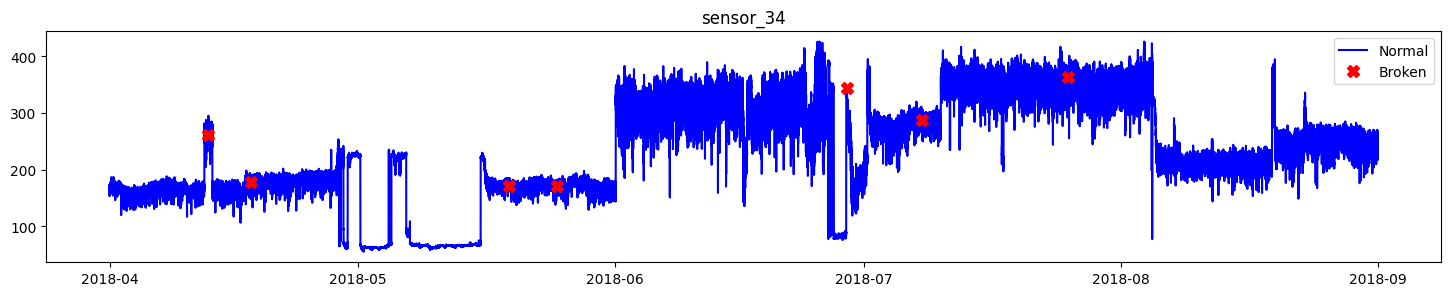

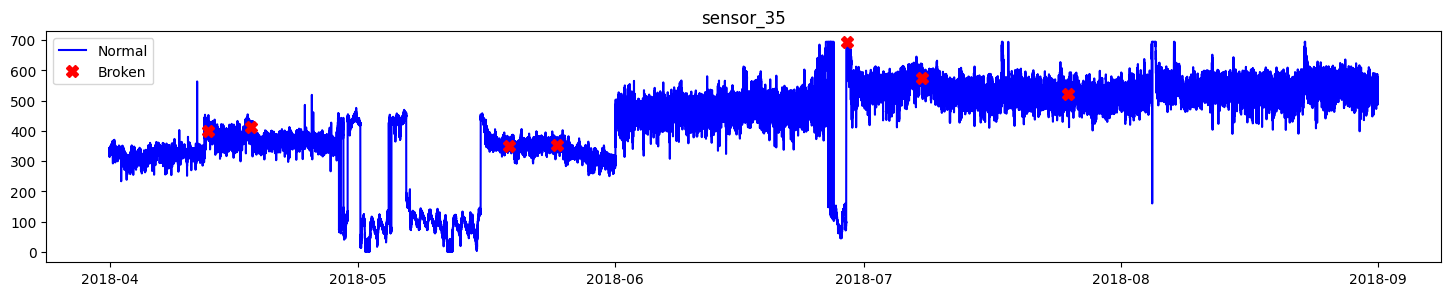

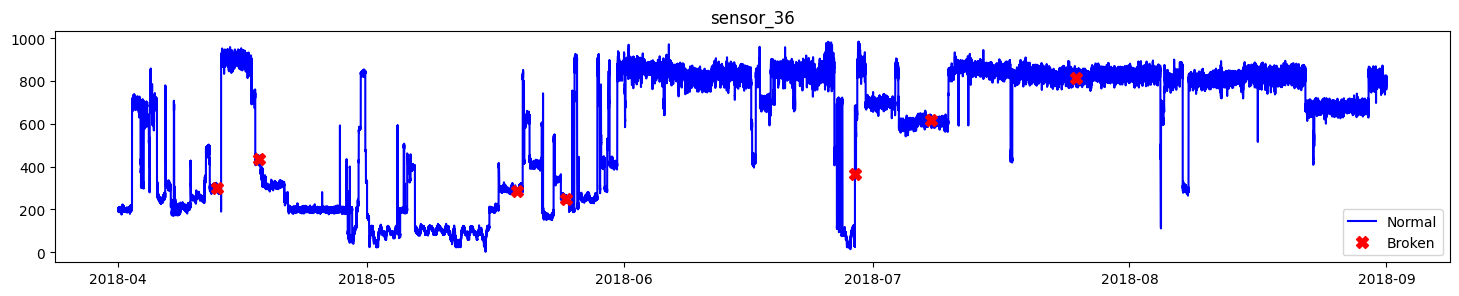

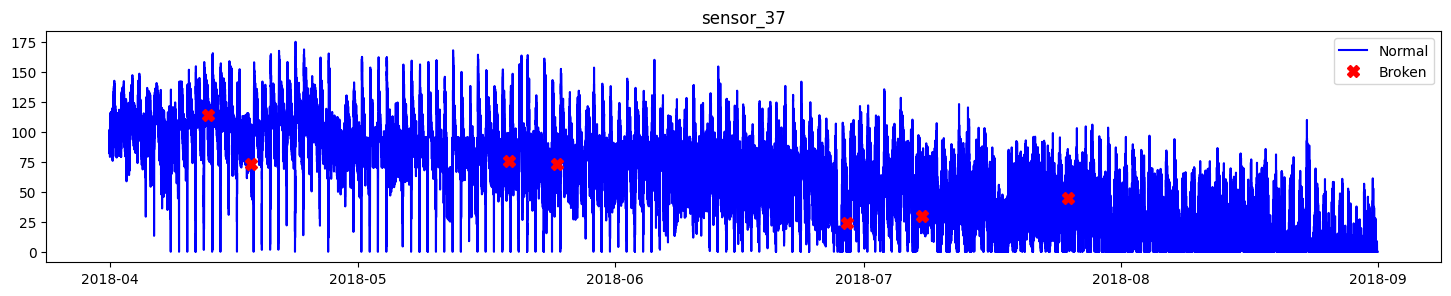

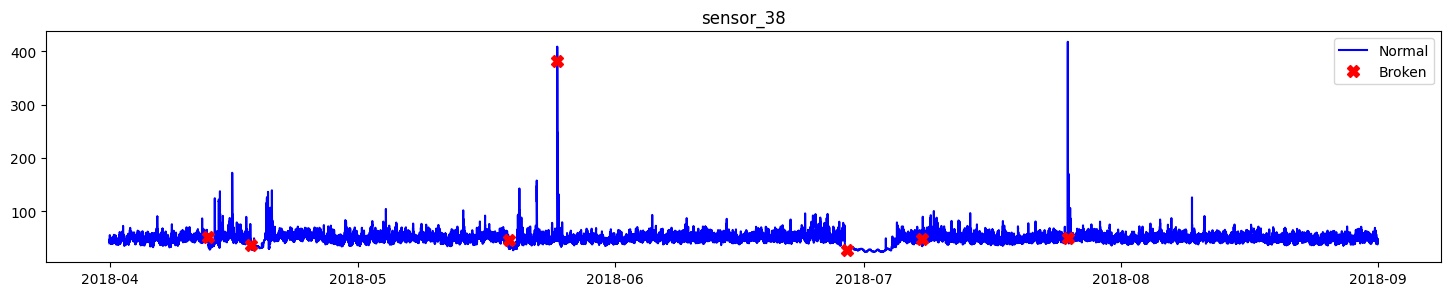

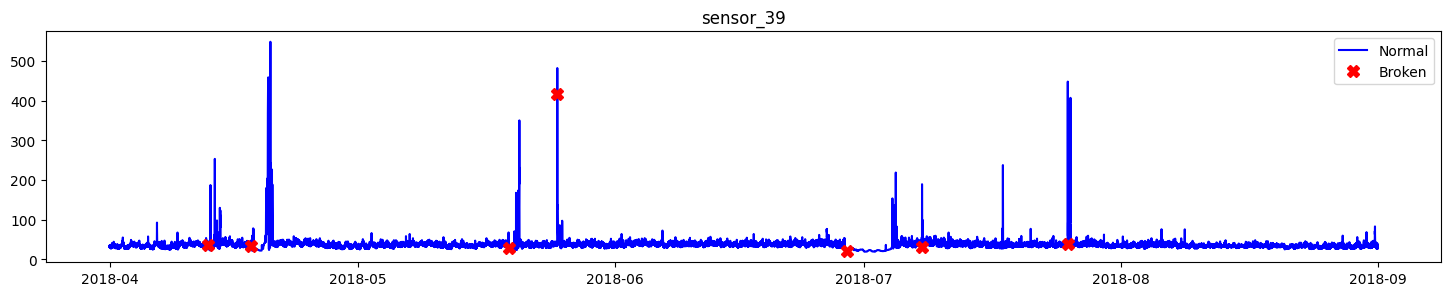

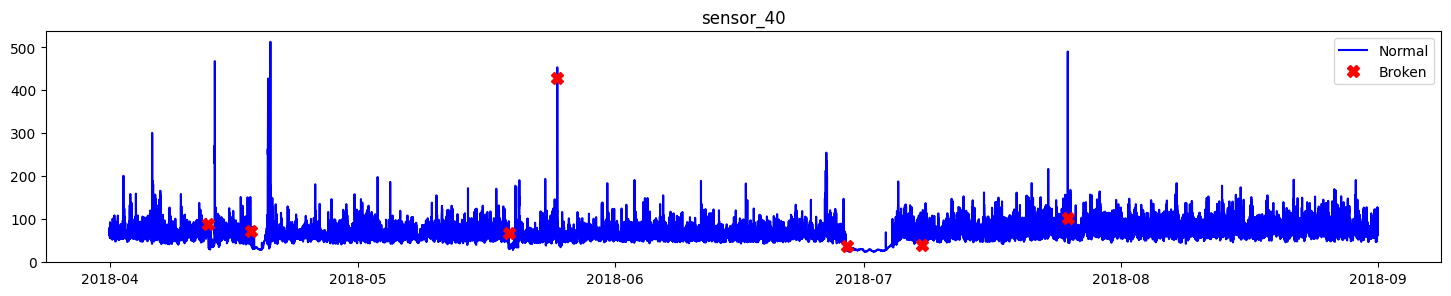

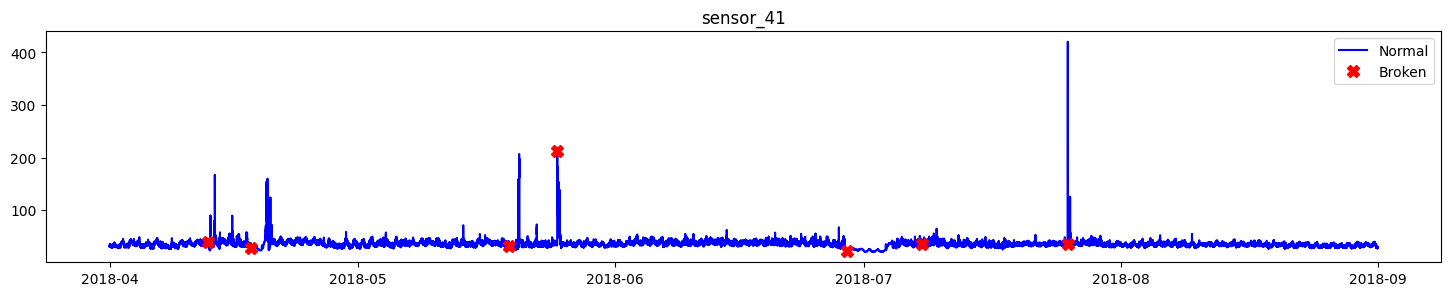

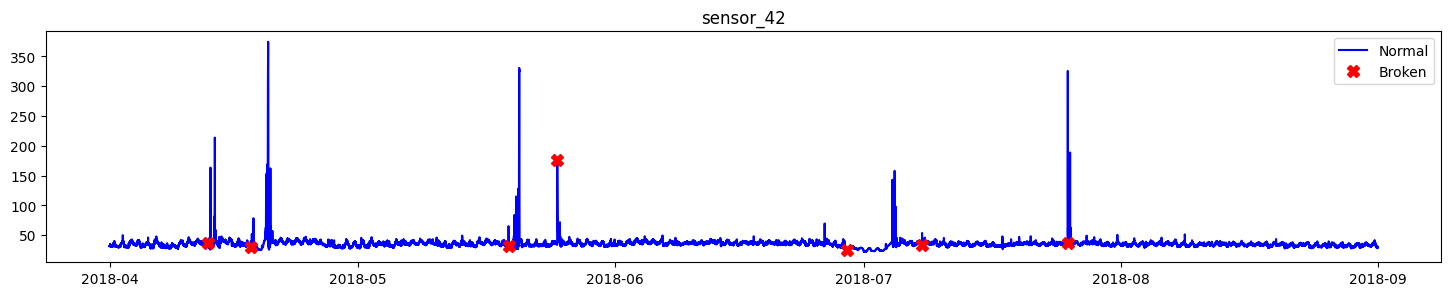

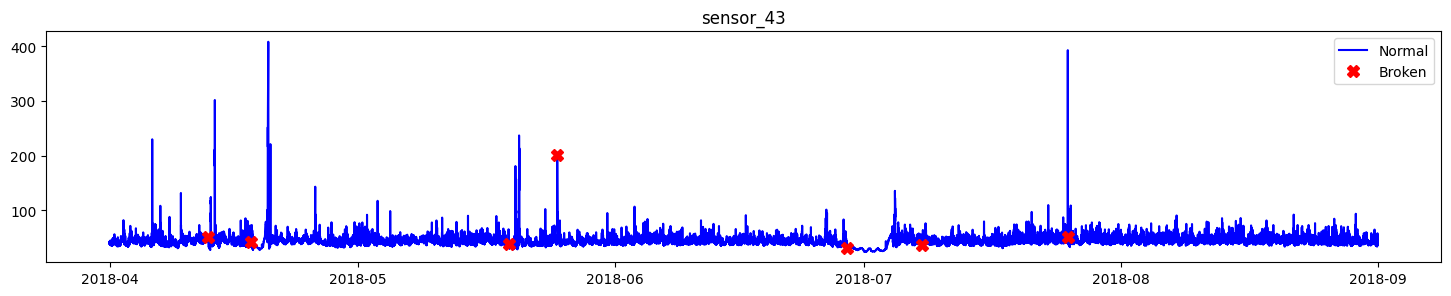

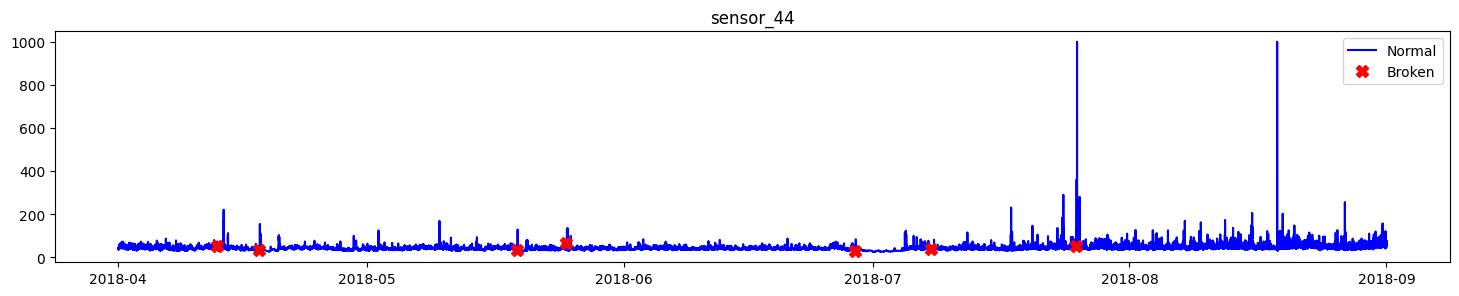

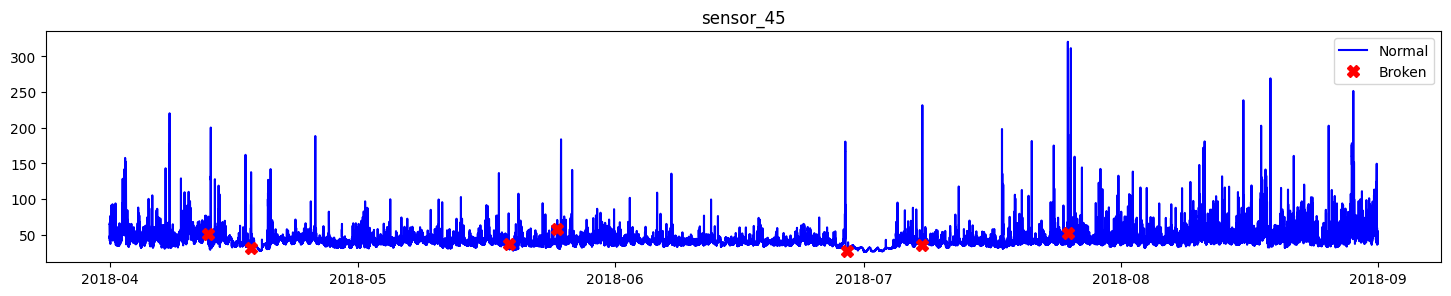

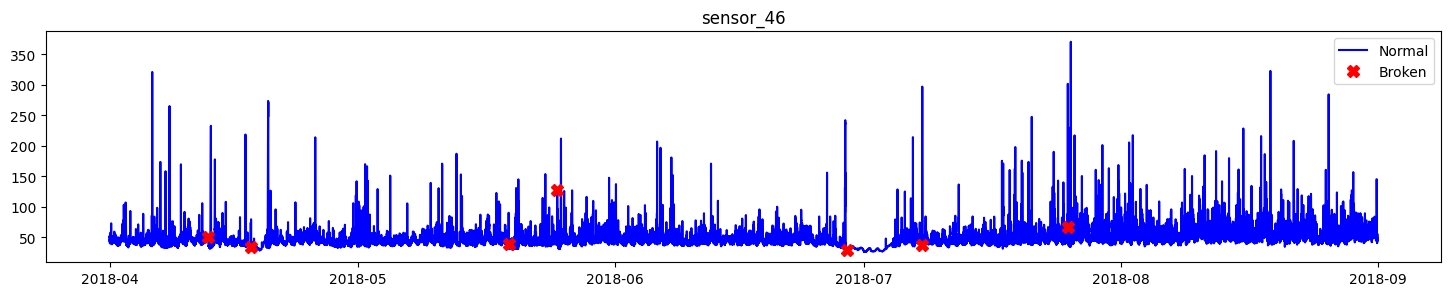

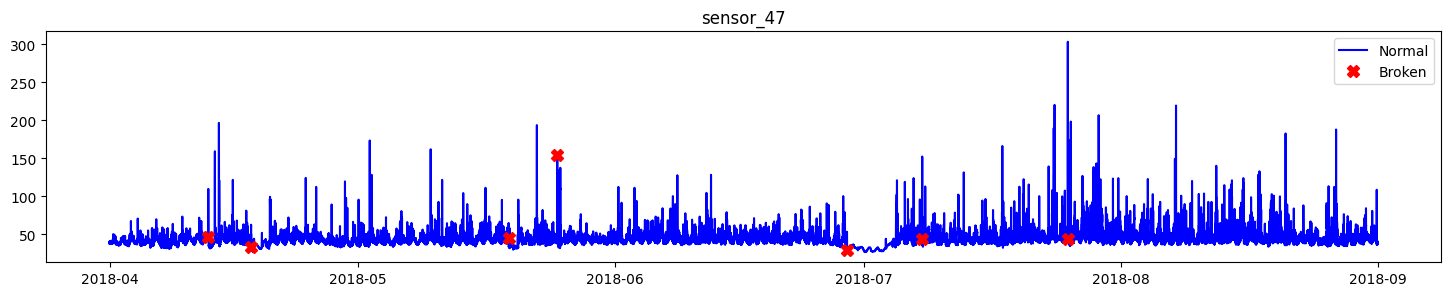

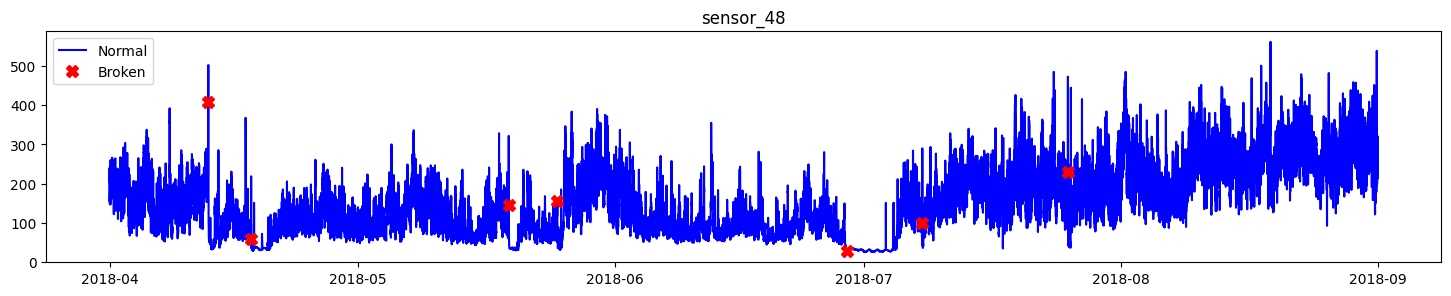

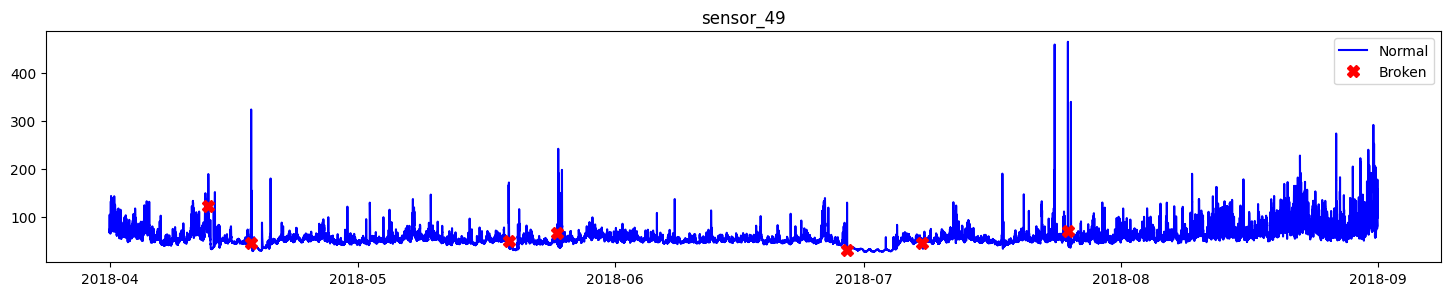

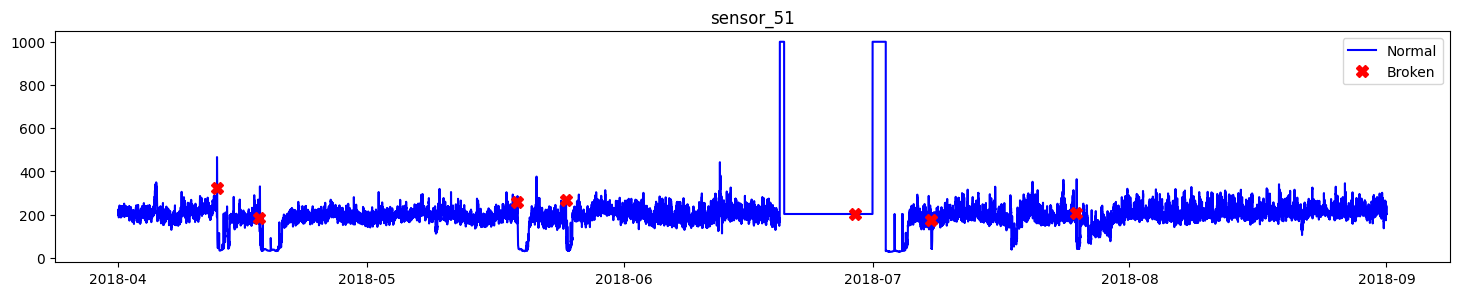

In [14]:
broken = df[df['machine_status']=='BROKEN']
sensor_cols = df.drop('machine_status', axis=1).columns

for name in sensor_cols:
    plt.figure(figsize=(18,3))
    plt.plot(df[name], label='Normal', color='blue')
    plt.plot(broken[name], linestyle='none', marker='X', color='red', markersize=8, label='Broken')
    plt.title(name)
    plt.legend()
    plt.show()


In [15]:
print(df.columns)

Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_51',
       'machine_status'],
      dtype='object')


## 11. Rolling Statistics (Daily)
Compute and plot the daily rolling mean and standard deviation for each sensor.


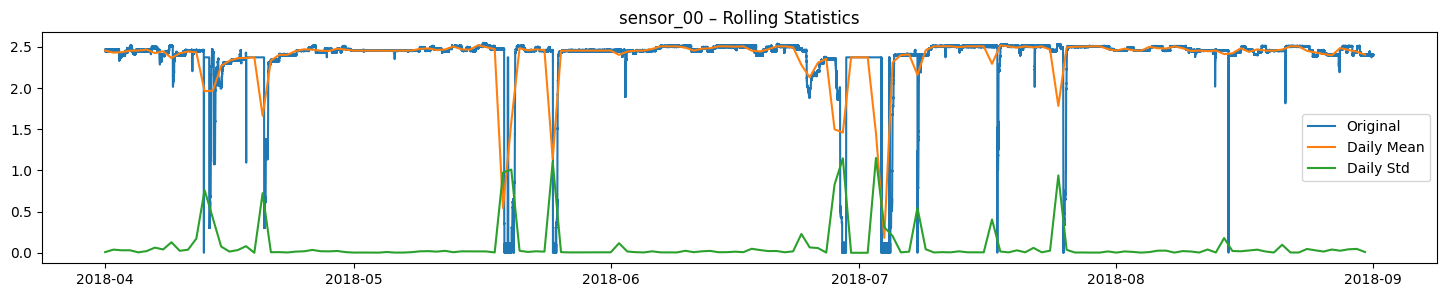

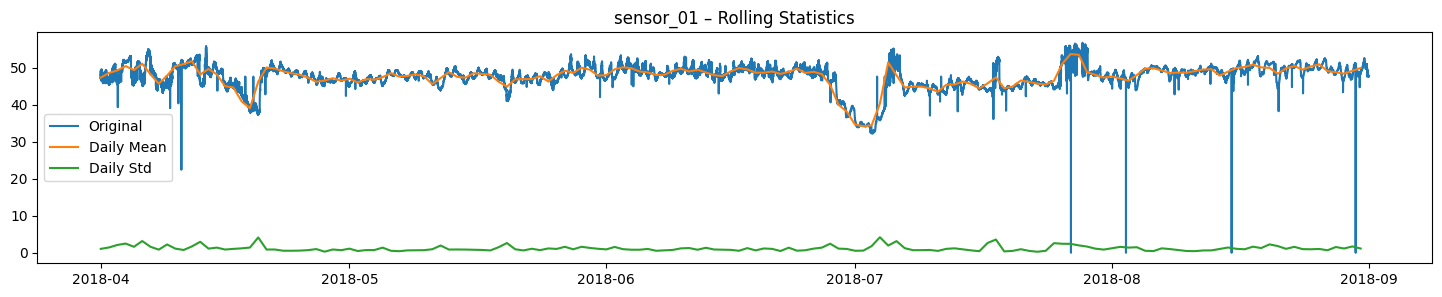

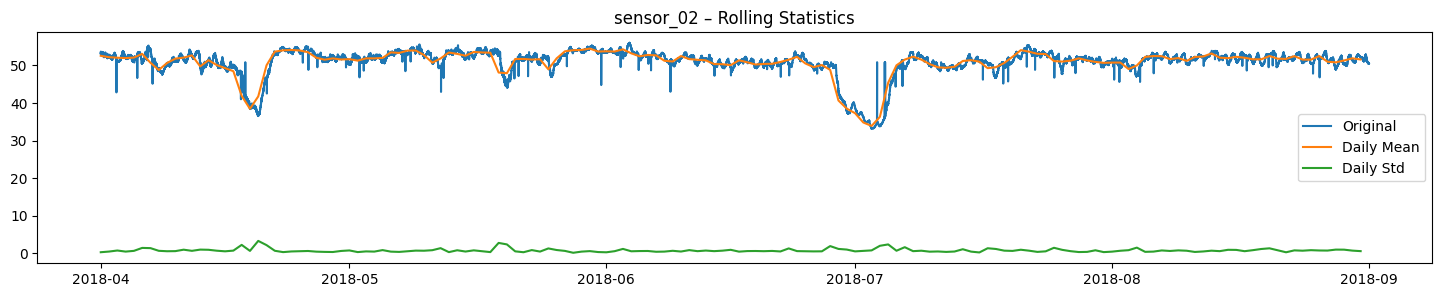

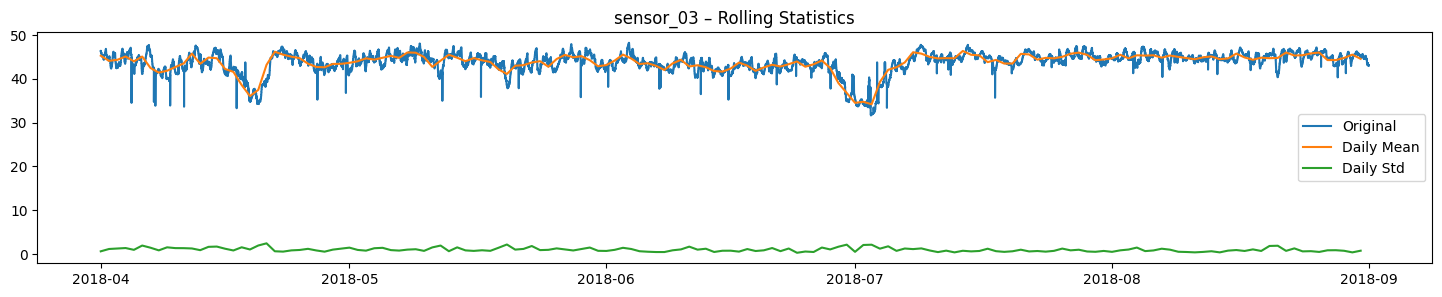

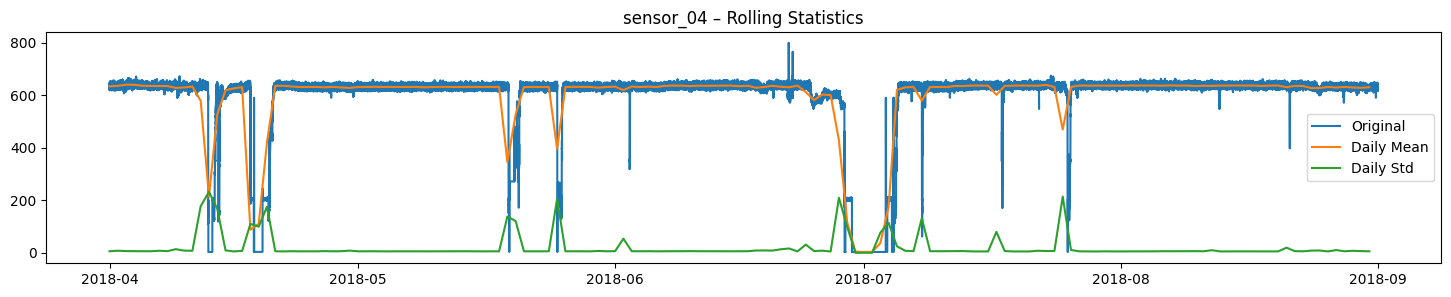

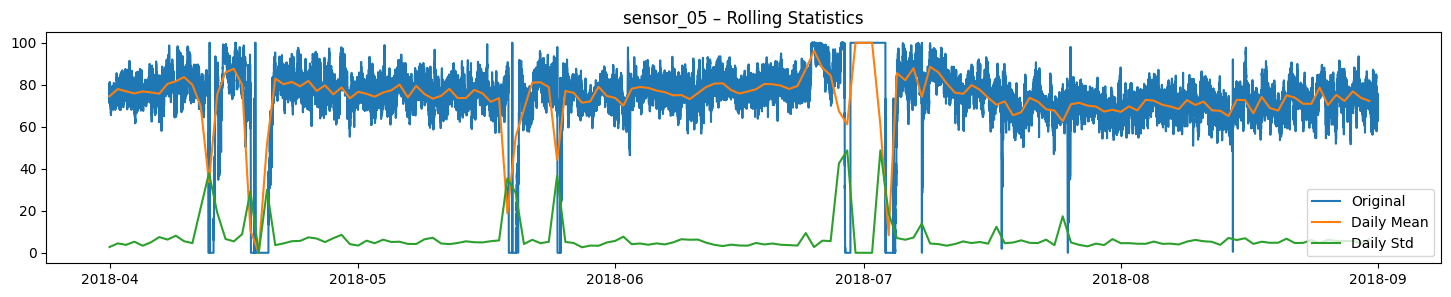

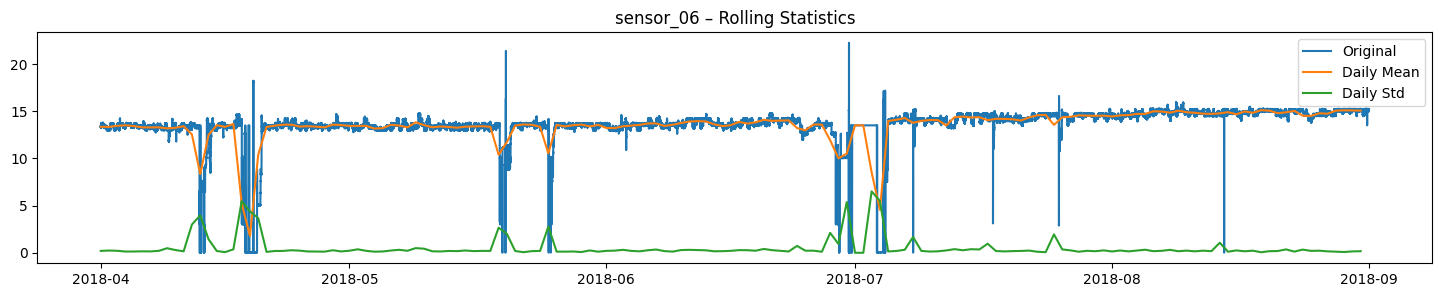

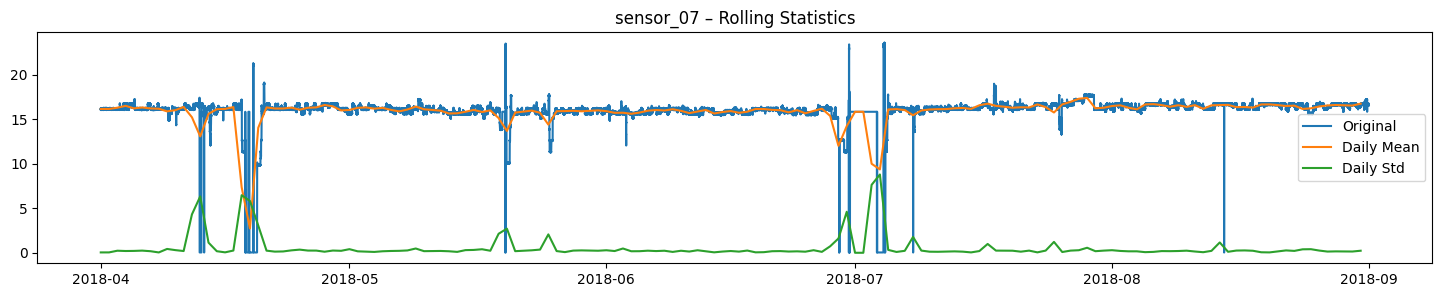

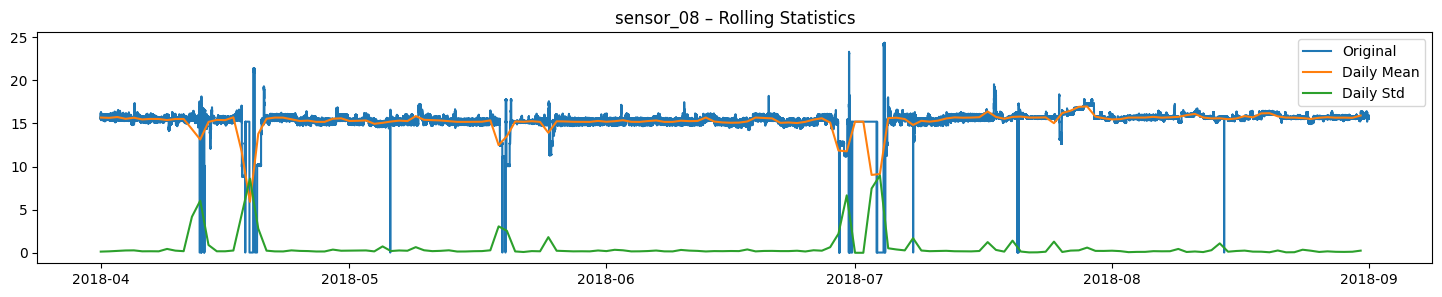

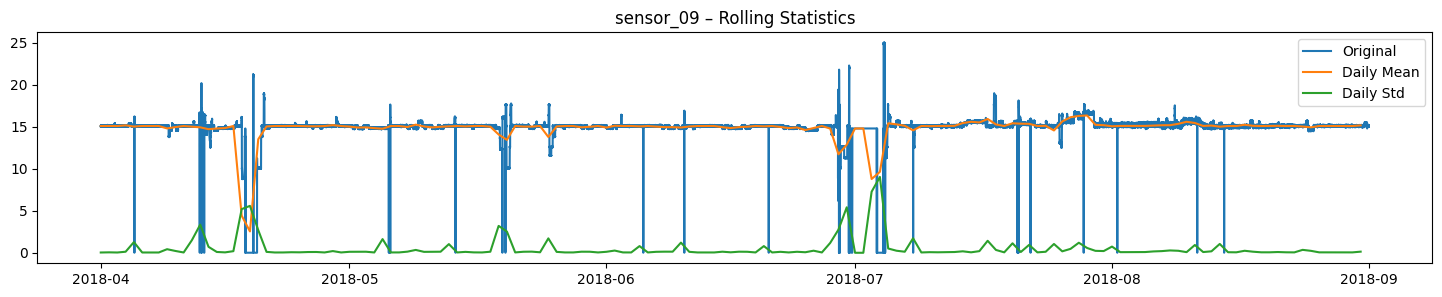

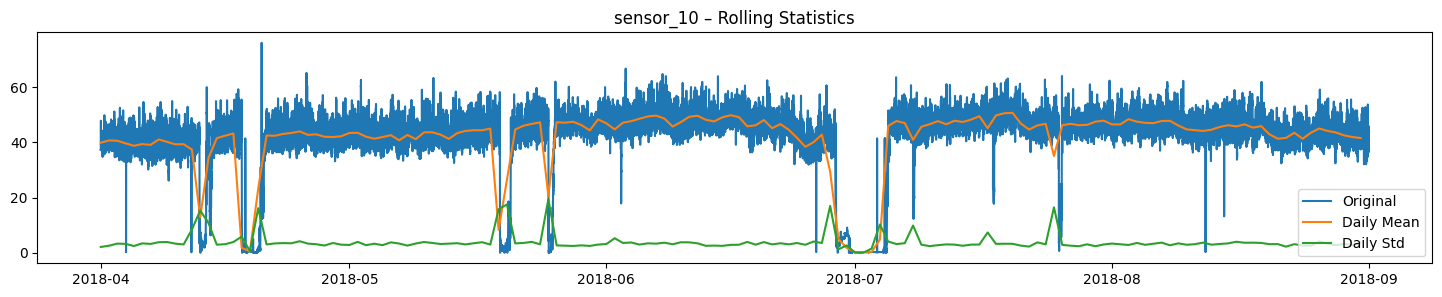

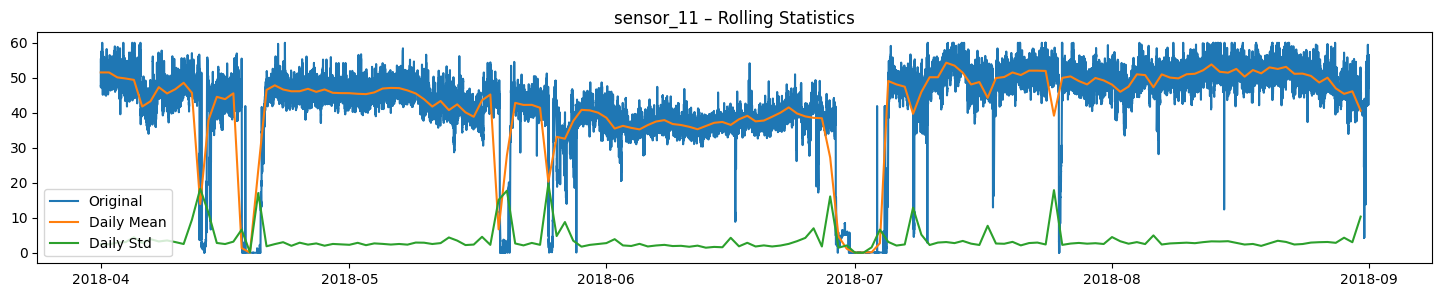

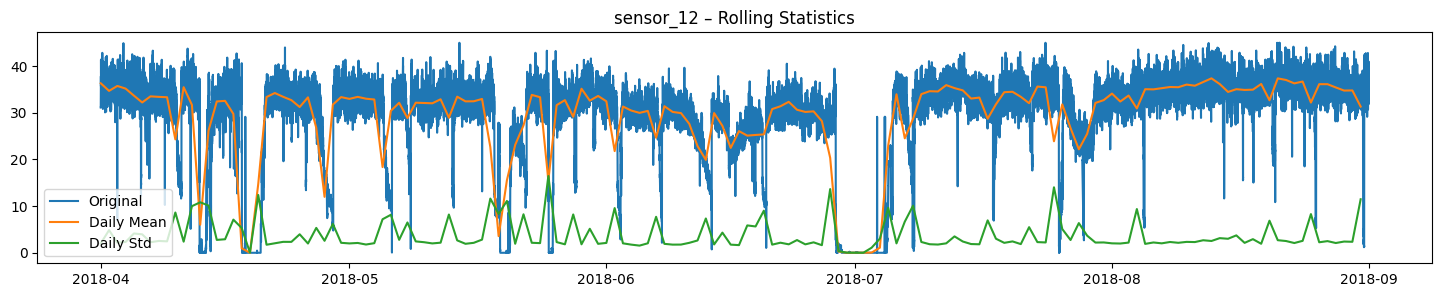

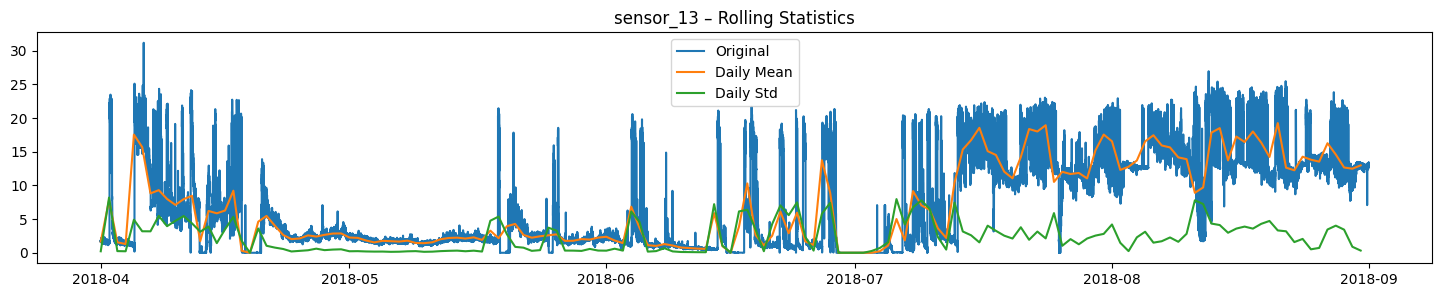

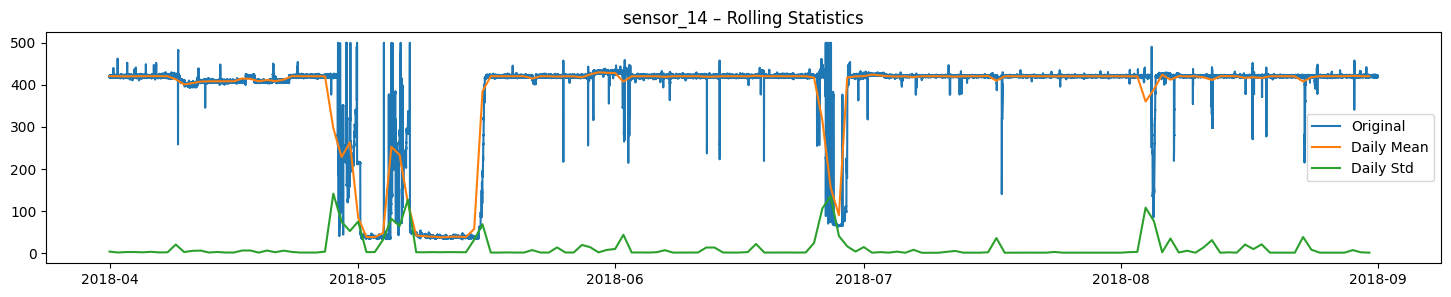

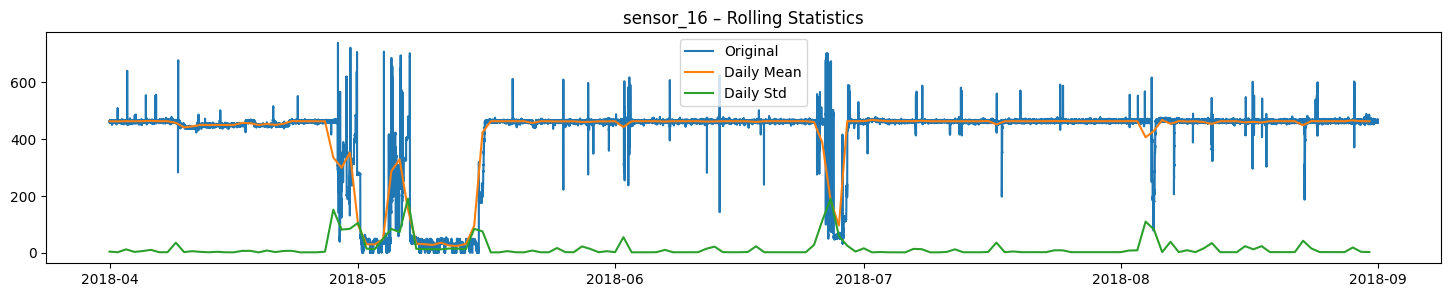

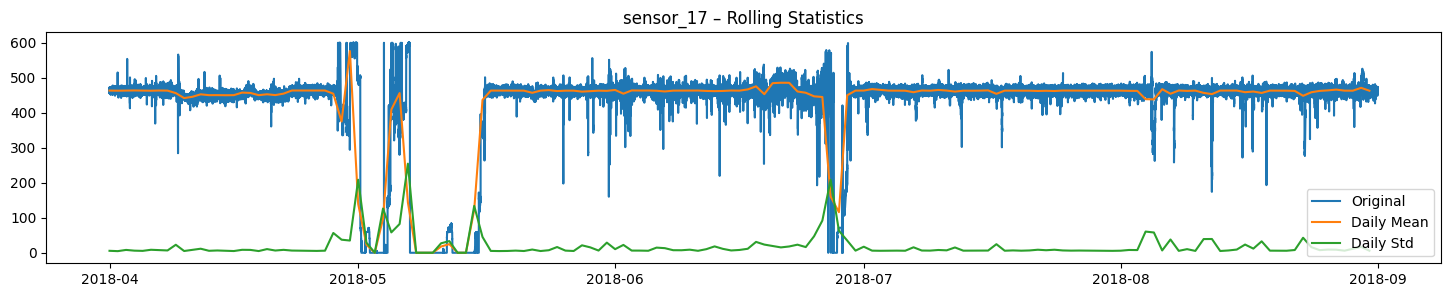

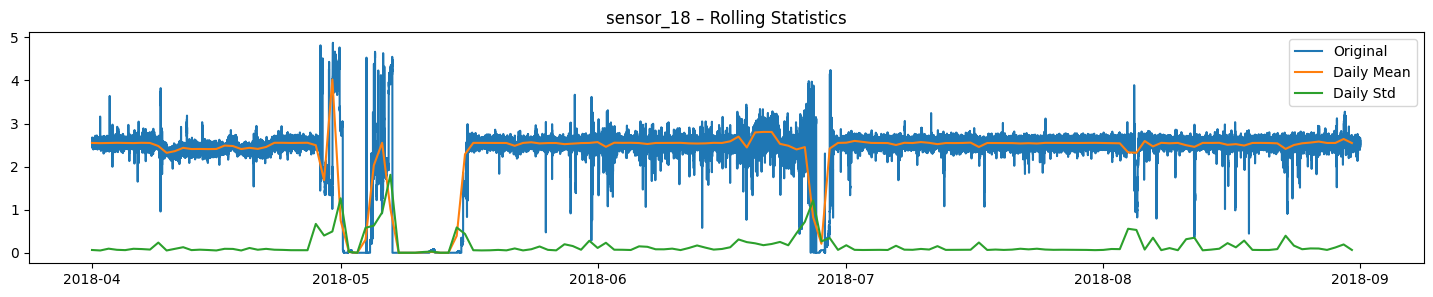

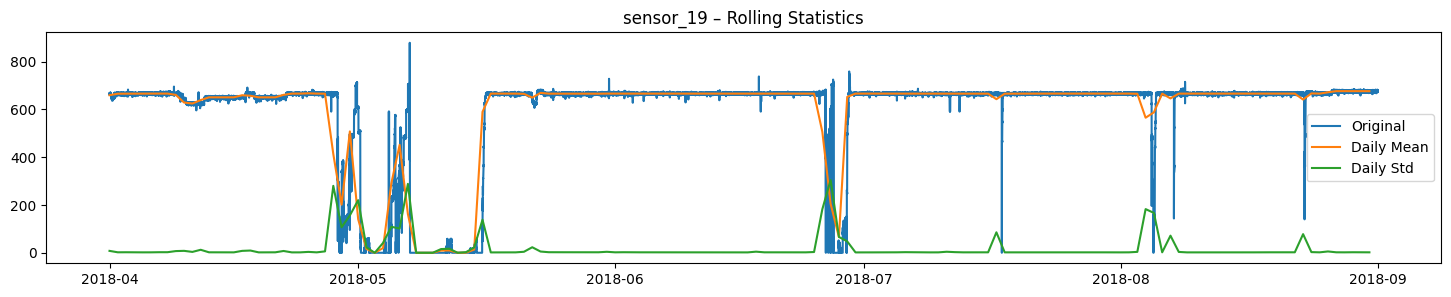

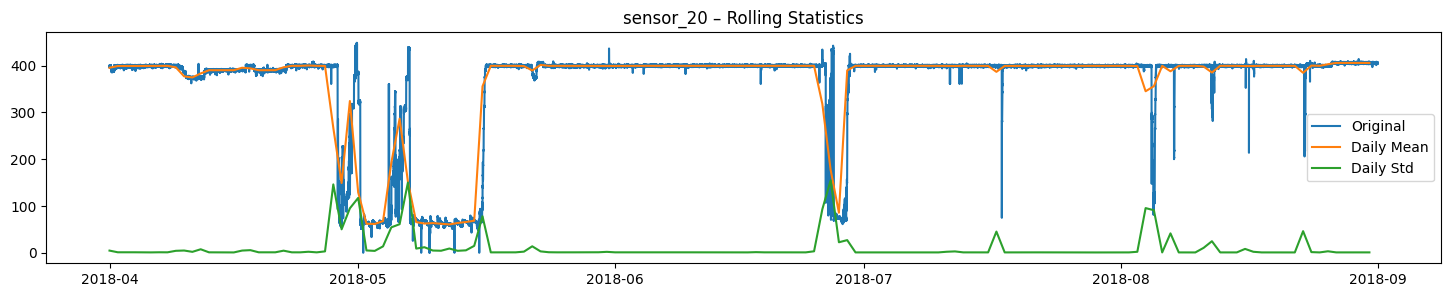

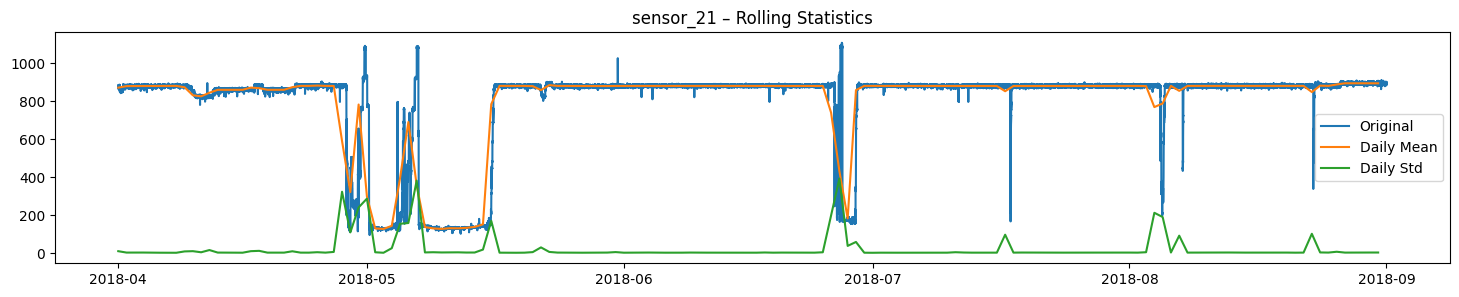

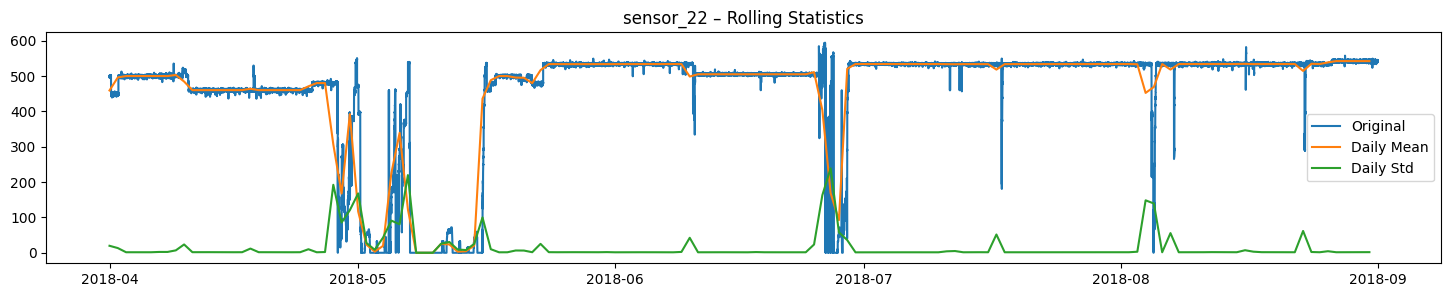

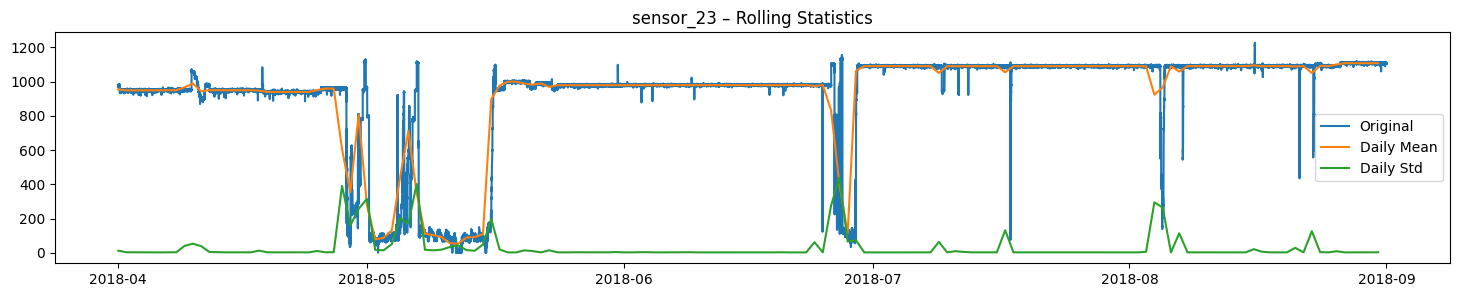

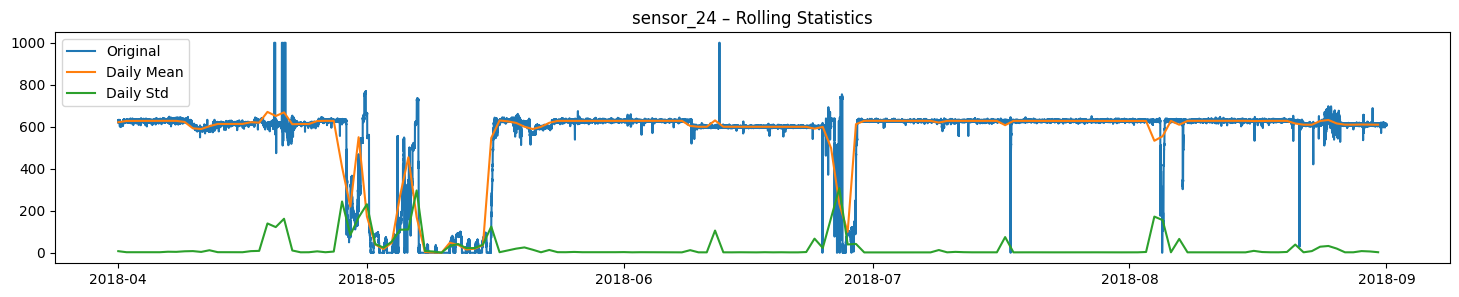

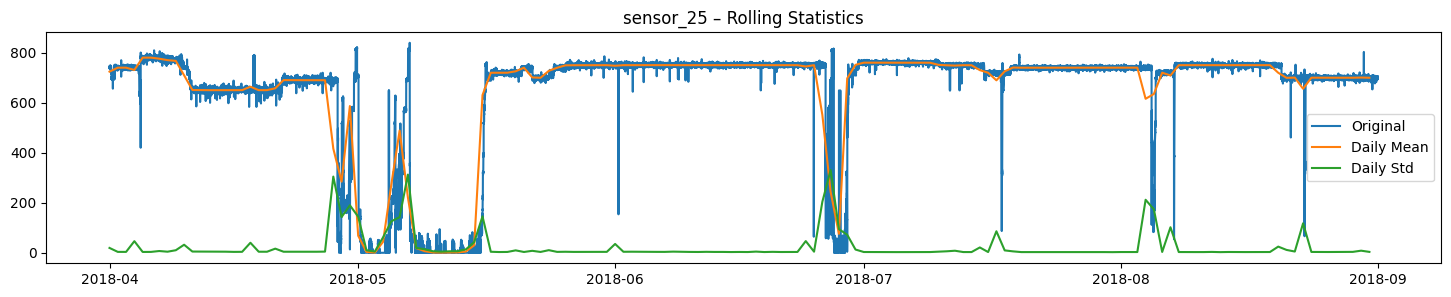

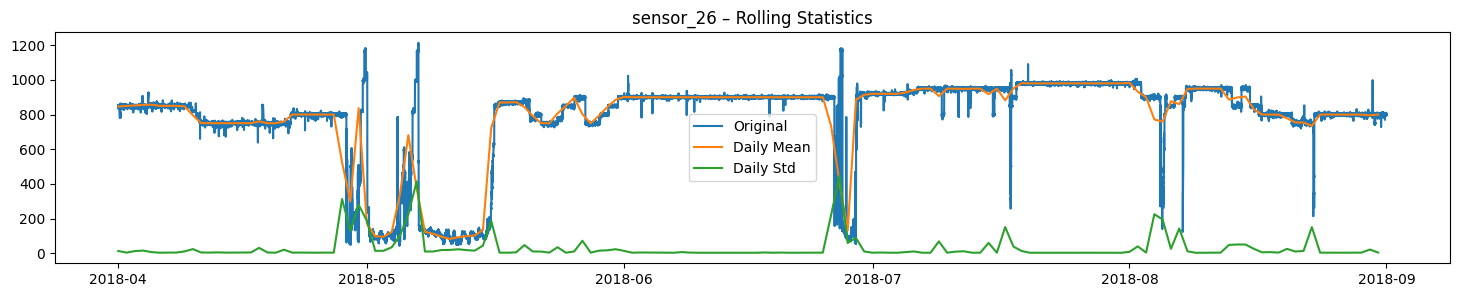

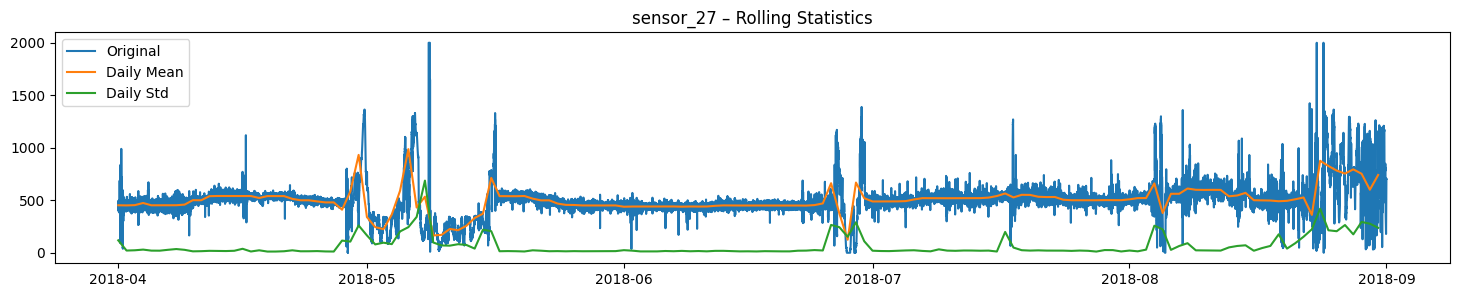

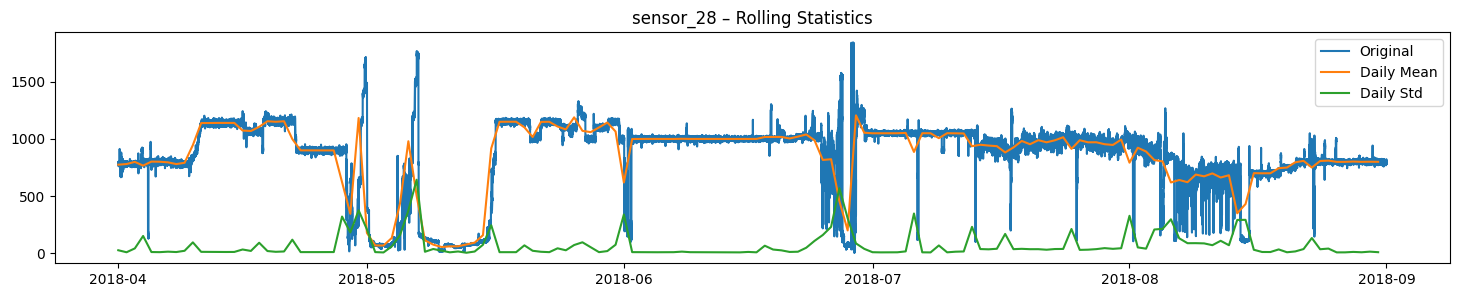

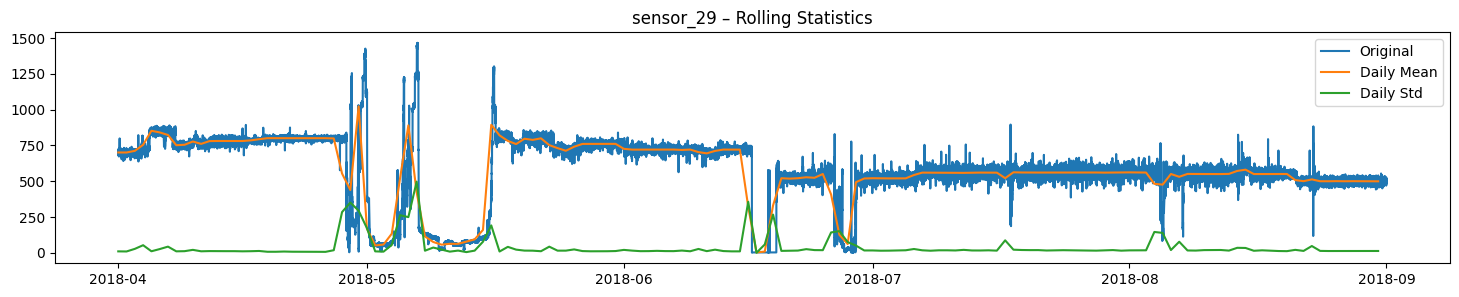

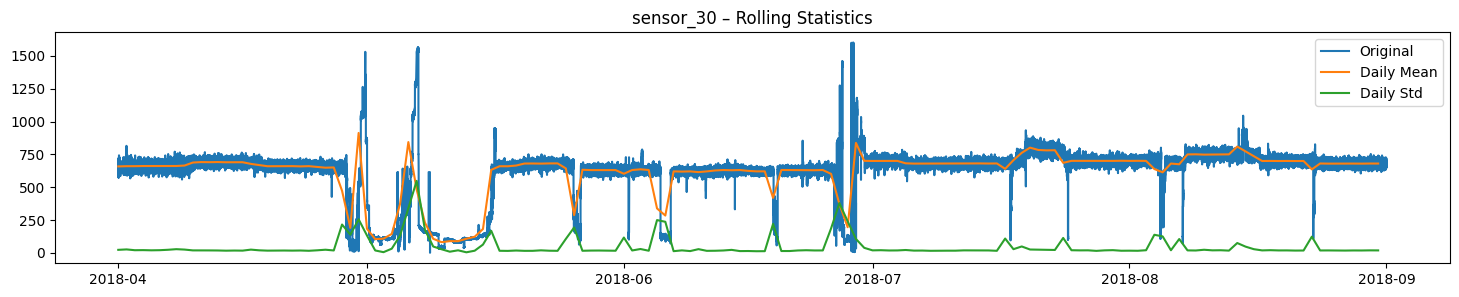

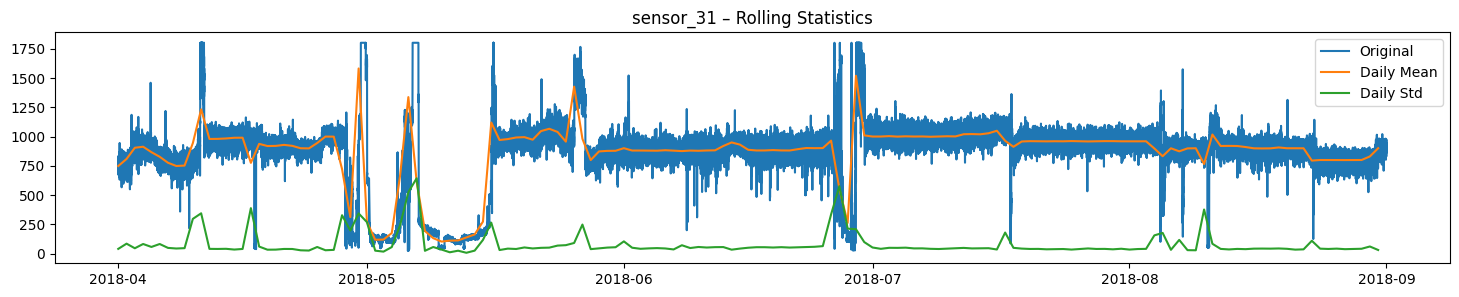

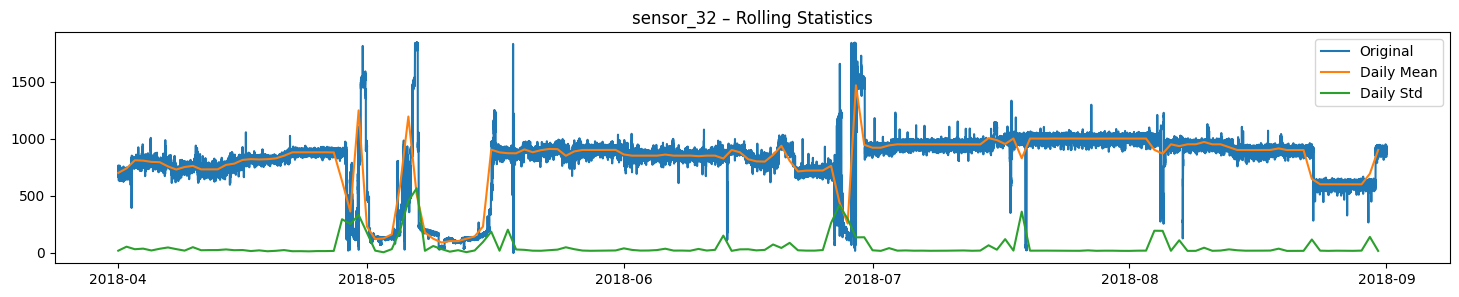

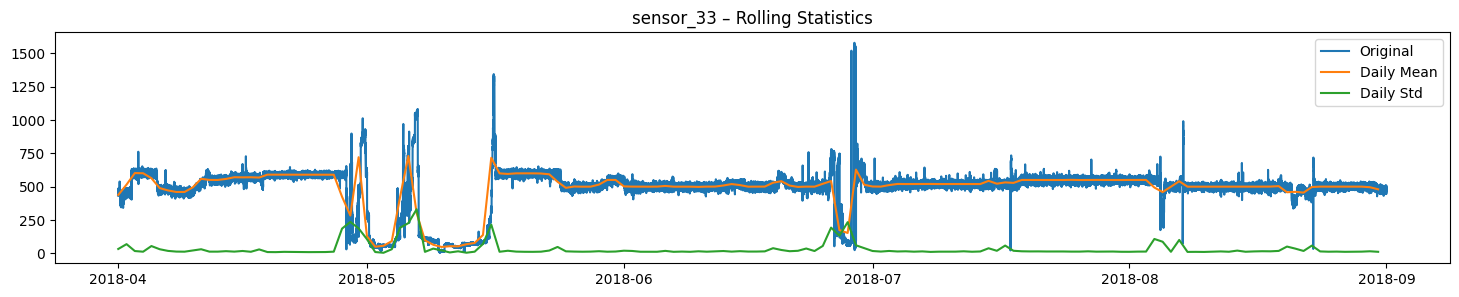

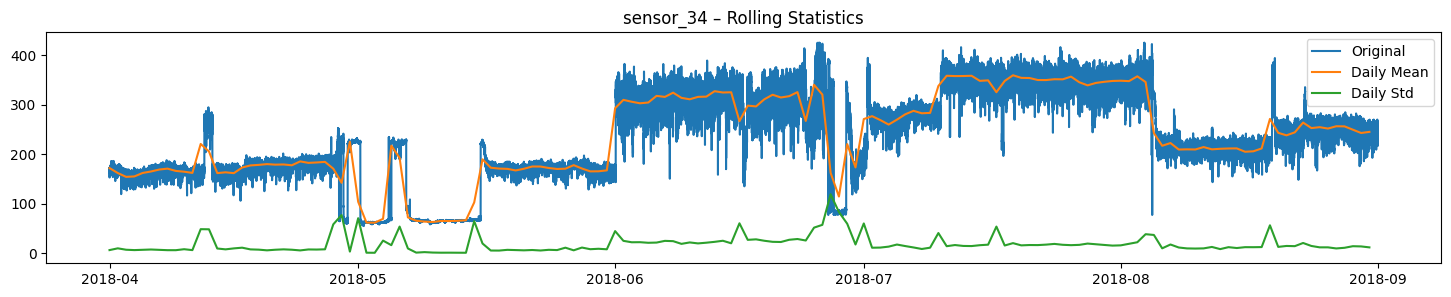

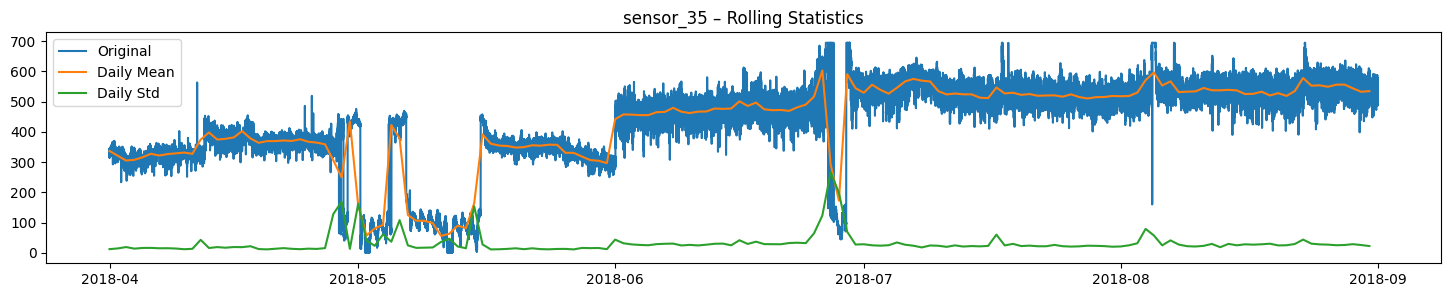

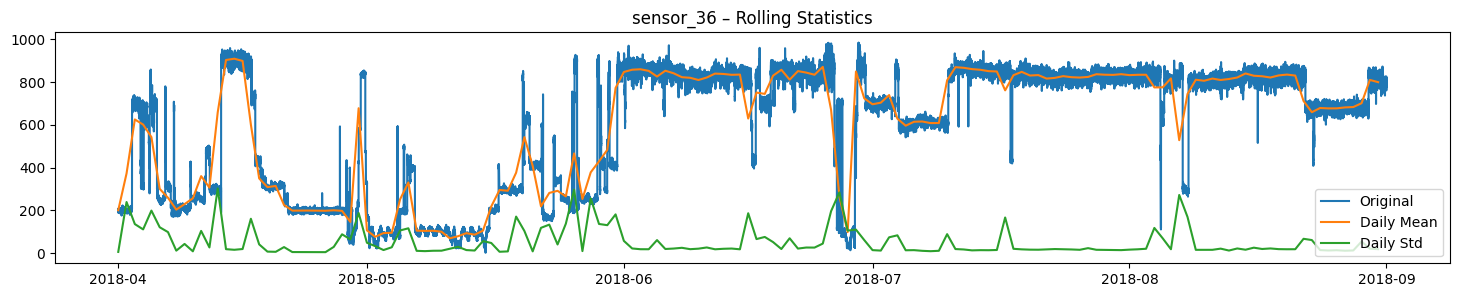

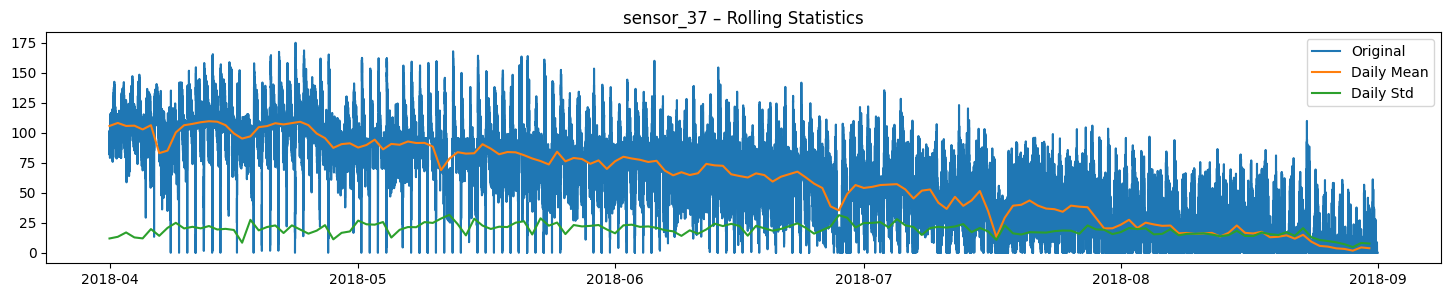

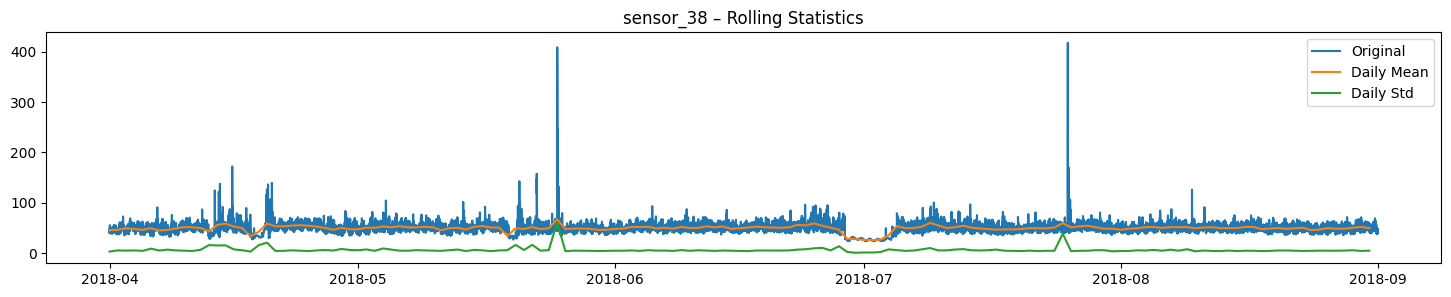

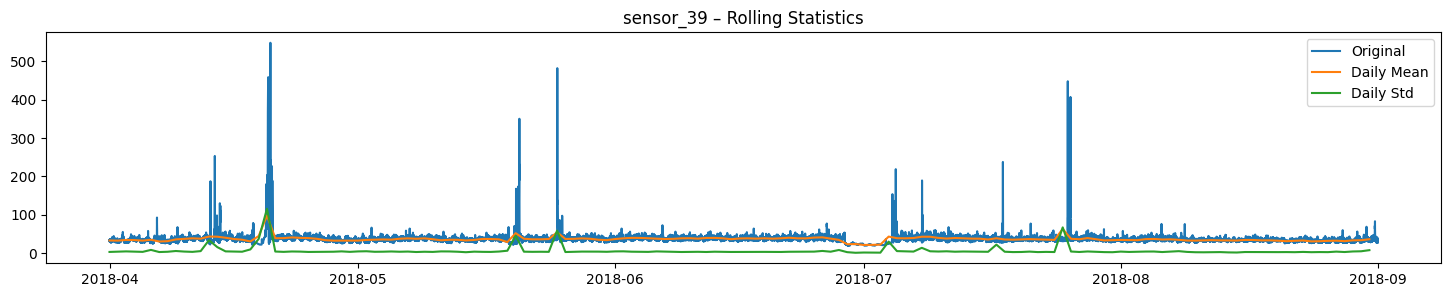

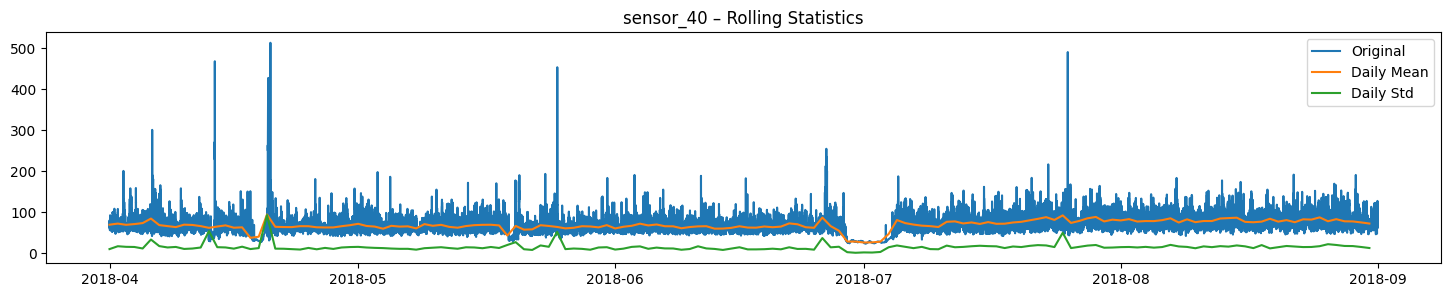

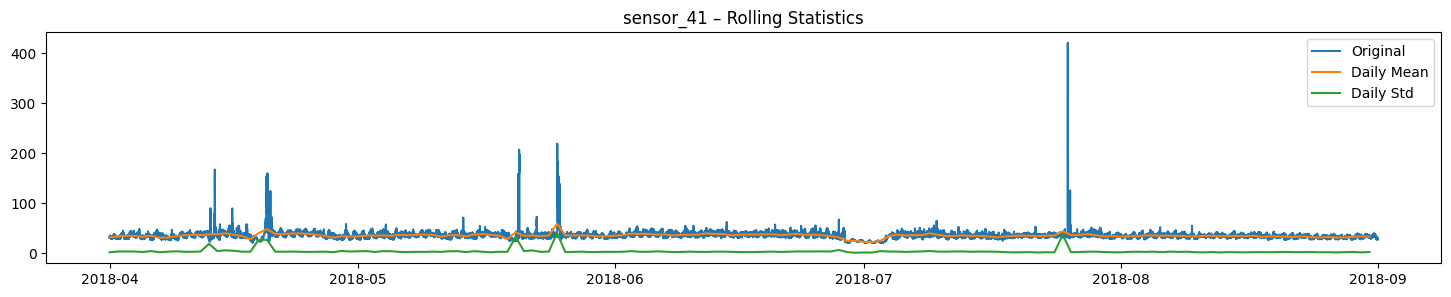

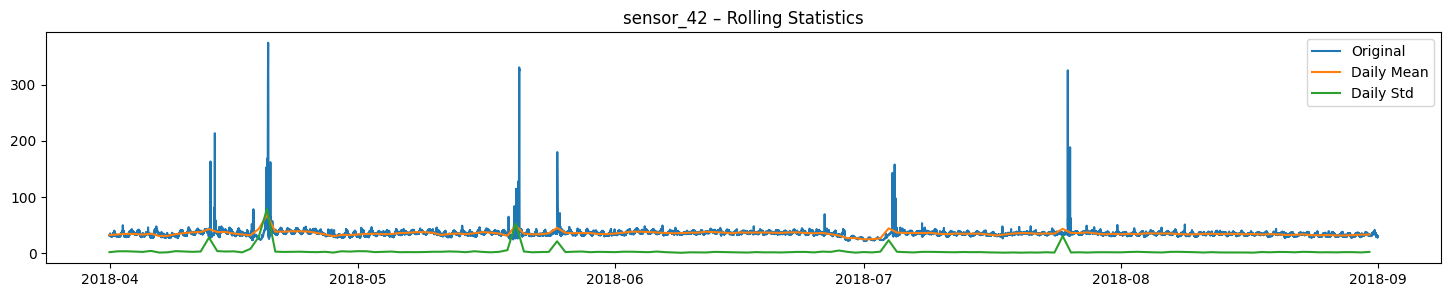

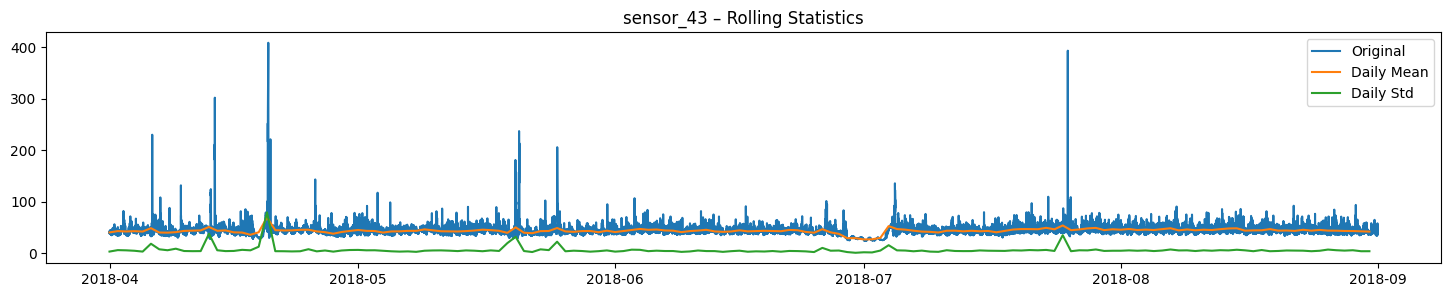

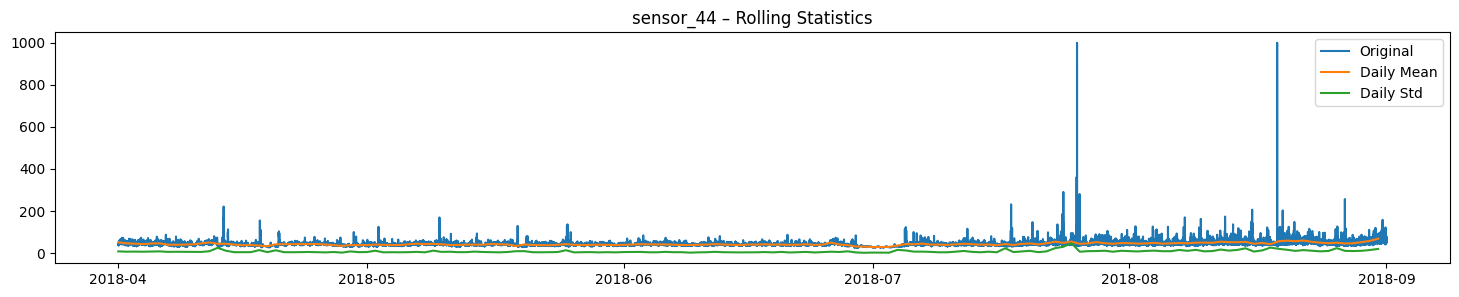

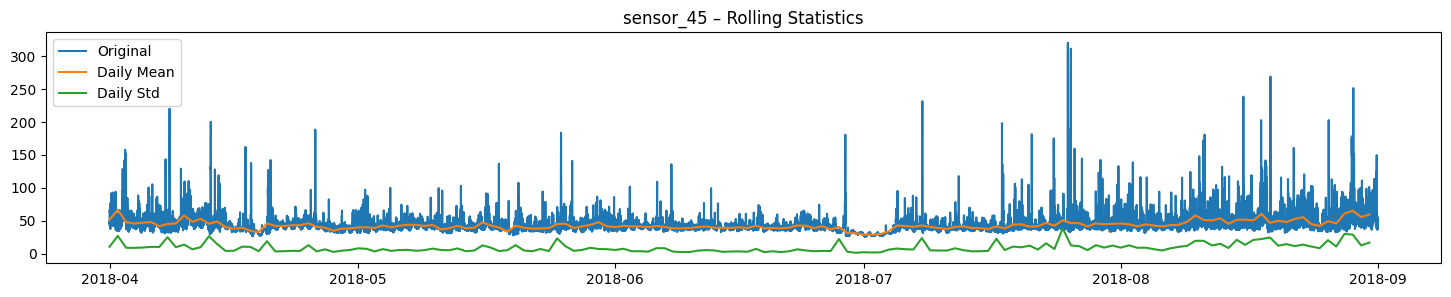

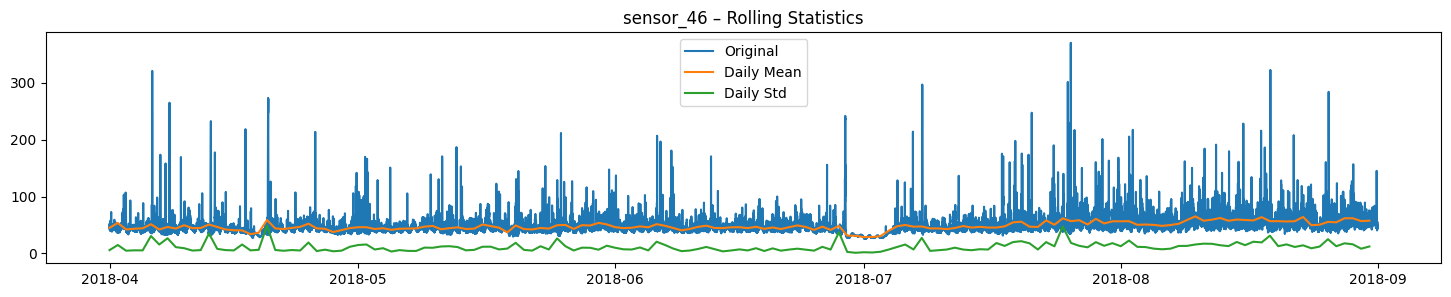

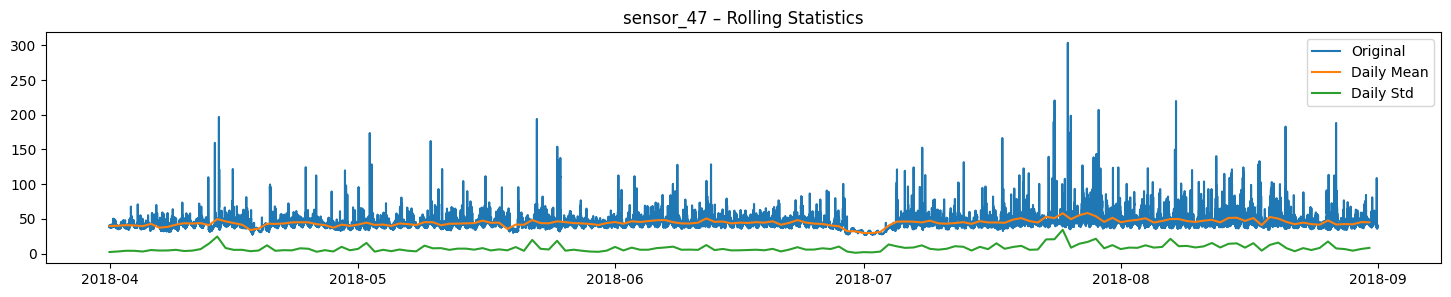

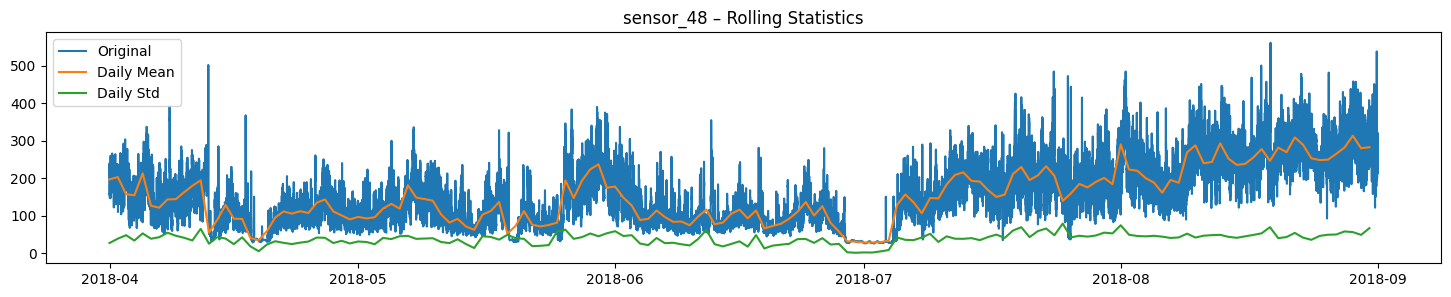

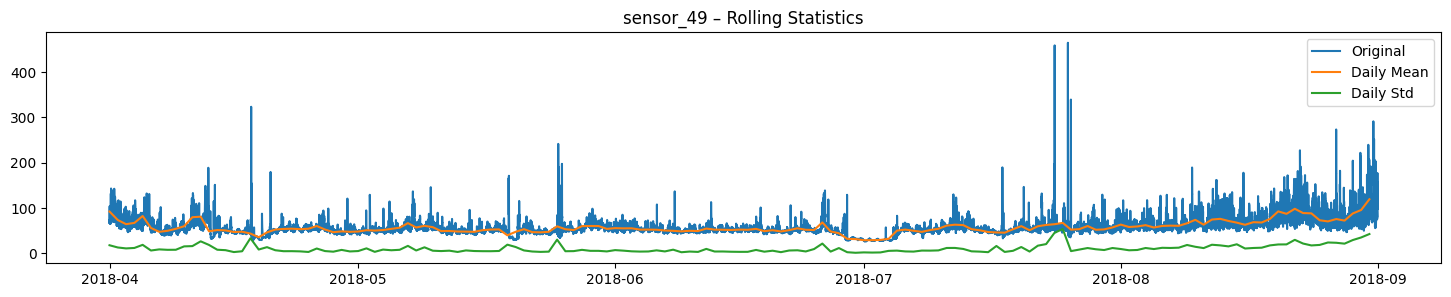

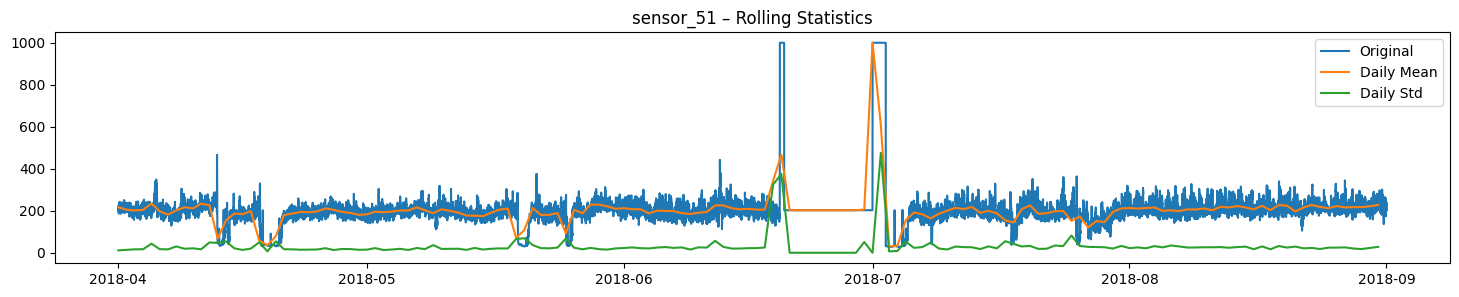

In [16]:
sensor_cols = [c for c in df.columns if c.startswith('sensor_')]
rollmean = df[sensor_cols].resample('D').mean()
rollstd  = df[sensor_cols].resample('D').std()
for name in sensor_cols:
    plt.figure(figsize=(18,3))
    plt.plot(df[name],       label='Original')
    plt.plot(rollmean[name], label='Daily Mean')
    plt.plot(rollstd[name],  label='Daily Std')
    plt.title(f'{name} – Rolling Statistics')
    plt.legend()
    plt.show()

## 12. PCA Analysis: Full Variance
Standardize the data and fit PCA to examine variance explained by all components.

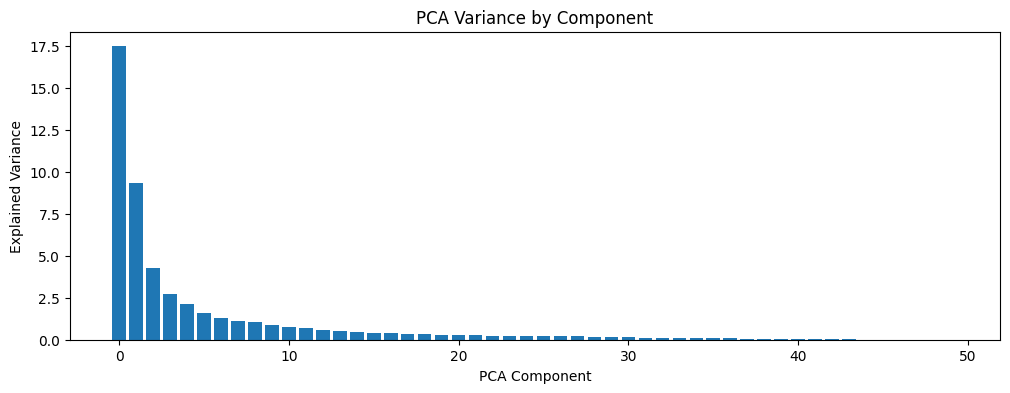

In [17]:
X = df[sensor_cols]
pipeline = make_pipeline(StandardScaler(), PCA())
pipeline.fit(X)

explained = pipeline.named_steps['pca'].explained_variance_
plt.figure(figsize=(12,4))
plt.bar(range(len(explained)), explained)
plt.xlabel('PCA Component')
plt.ylabel('Explained Variance')
plt.title('PCA Variance by Component')
plt.show()


# 13. PCA with Two Components
Reduce to two principal components and attach them back to the DataFrame.

In [18]:
pca2 = PCA(n_components=2)
pcs   = pca2.fit_transform(StandardScaler().fit_transform(X))
pc_df = pd.DataFrame(pcs, columns=['pc1','pc2'], index=df.index)

df['pc1'] = pc_df['pc1']
df['pc2'] = pc_df['pc2']
df.head()


sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  \
date                                                                         
2018-04-01 00:00:00   2.465394   47.09201    53.2118  46.310760   634.3750   
2018-04-01 00:01:00   2.465394   47.09201    53.2118  46.310760   634.3750   
2018-04-01 00:02:00   2.444734   47.35243    53.2118  46.397570   638.8889   
2018-04-01 00:03:00   2.460474   47.09201    53.1684  46.397568   628.1250   
2018-04-01 00:04:00   2.445718   47.13541    53.2118  46.397568   636.4583   

                     sensor_05  sensor_06  sensor_07  sensor_08  sensor_09  \
date                                                                         
2018-04-01 00:00:00   76.45975   13.41146   16.13136   15.56713   15.05353   
2018-04-01 00:01:00   76.45975   13.41146   16.13136   15.56713   15.05353   
2018-04-01 00:02:00   73.54598   13.32465   16.03733   15.61777   15.01013   
2018-04-01 00:03:00   76.98898   13.31742   16.24711   15.69734   15.08247   
2018-04-01 00:04:00   76.58897   13.35359   16.21094   15.69734   15.08247   

                     ...  sensor_44  sensor_45  sensor_46  sensor_47  \
date                 ...                                               
2018-04-01 00:00:00  ...  39.641200   65.68287   50.92593  38.194440   
2018-04-01 00:01:00  ...  39.641200   65.68287   50.92593  38.194440   
2018-04-01 00:02:00  ...  39.351852   65.39352   51.21528  38.194443   
2018-04-01 00:03:00  ...  39.062500   64.81481   51.21528  38.194440   
2018-04-01 00:04:00  ...  38.773150   65.10416   51.79398  38.773150   

                     sensor_48  sensor_49  sensor_51  machine_status  \
date                                                                   
2018-04-01 00:00:00   157.9861   67.70834   201.3889          NORMAL   
2018-04-01 00:01:00   157.9861   67.70834   201.3889          NORMAL   
2018-04-01 00:02:00   155.9606   67.12963   203.7037          NORMAL   
2018-04-01 00:03:00   155.9606   66.84028   203.1250          NORMAL   
2018-04-01 00:04:00   158.2755   66.55093   201.3889          NORMAL   

                          pc1       pc2  
date                                     
2018-04-01 00:00:00  0.046056  0.490524  
2018-04-01 00:01:00  0.046056  0.490524  
2018-04-01 00:02:00  0.186309  0.500354  
2018-04-01 00:03:00  0.186651  0.538034  
2018-04-01 00:04:00  0.142655  0.645878  

[5 rows x 53 columns]

## 14. Stationarity Tests (ADF)
Check stationarity of each principal component via the Augmented Dickey–Fuller test.

In [19]:
print('pc1 p-value:', adfuller(pc_df['pc1'])[1])
print('pc2 p-value:', adfuller(pc_df['pc2'])[1])


pc1 p-value: 0.00014222614547470118
pc2 p-value: 1.9319528833110932e-10


## 15. Autocorrelation Analysis
Compute percent-change autocorrelation and plot ACF for each PC.

pc1 autocorr: -7.21617162404855e-06


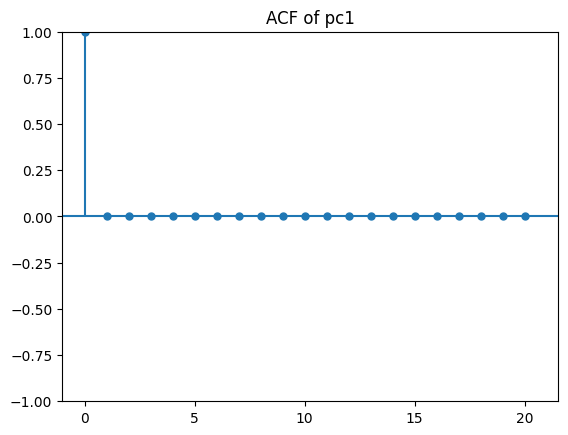

pc2 autocorr: -3.901549191146405e-07


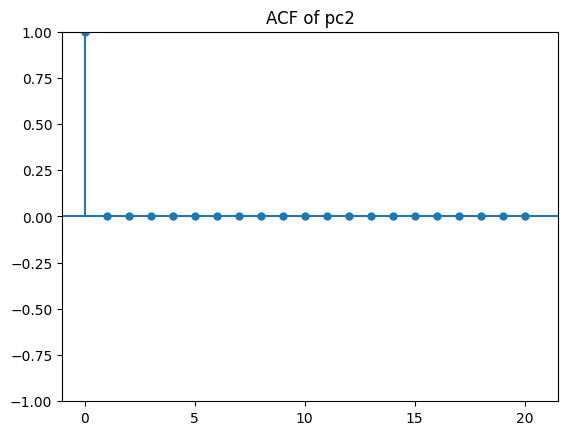

In [20]:
for pc in ['pc1','pc2']:
    pct = pc_df[pc].pct_change().dropna()
    print(f'{pc} autocorr:', pct.autocorr())
    plot_acf(pct, lags=20, alpha=0.05)
    plt.title(f'ACF of {pc}')
    plt.show()


## 16. Outlier Bounds via IQR
Derive upper/lower bounds for anomalies on pc1 and pc2, then flag anomalies.

In [21]:
def iqr_bounds(series):
    q1, q3 = series.quantile([.25,.75])
    iqr = q3 - q1
    return q1 - 1.5*iqr, q3 + 1.5*iqr

low1, up1 = iqr_bounds(df['pc1'])
low2, up2 = iqr_bounds(df['pc2'])

df['anomaly_pc1'] = ((df['pc1']<low1) | (df['pc1']>up1)).astype(int)
df['anomaly_pc2'] = ((df['pc2']<low2) | (df['pc2']>up2)).astype(int)

print('Anomalies pc1:', df['anomaly_pc1'].sum())
print('Anomalies pc2:', df['anomaly_pc2'].sum())


Anomalies pc1: 28476
Anomalies pc2: 18071


## 17. Feature Selection (Univariate)
Identify the top 3 sensor features correlated with machine_status via chi-squared.



In [22]:
X_fs = MinMaxScaler().fit_transform(df[sensor_cols])
y_fs = df['machine_status']

skb = SelectKBest(chi2, k=3).fit(X_fs, y_fs)
scores = pd.Series(skb.scores_, index=sensor_cols)
print('Top 3 features:\n', scores.nlargest(3))


Top 3 features:
 sensor_11    10123.423188
sensor_12     9893.118661
sensor_04     8183.512414
dtype: float64


## 18. Visualize PCA-Based Anomalies on Sensor_11
Plot where pc1-based anomalies occur in the time series of sensor_11.

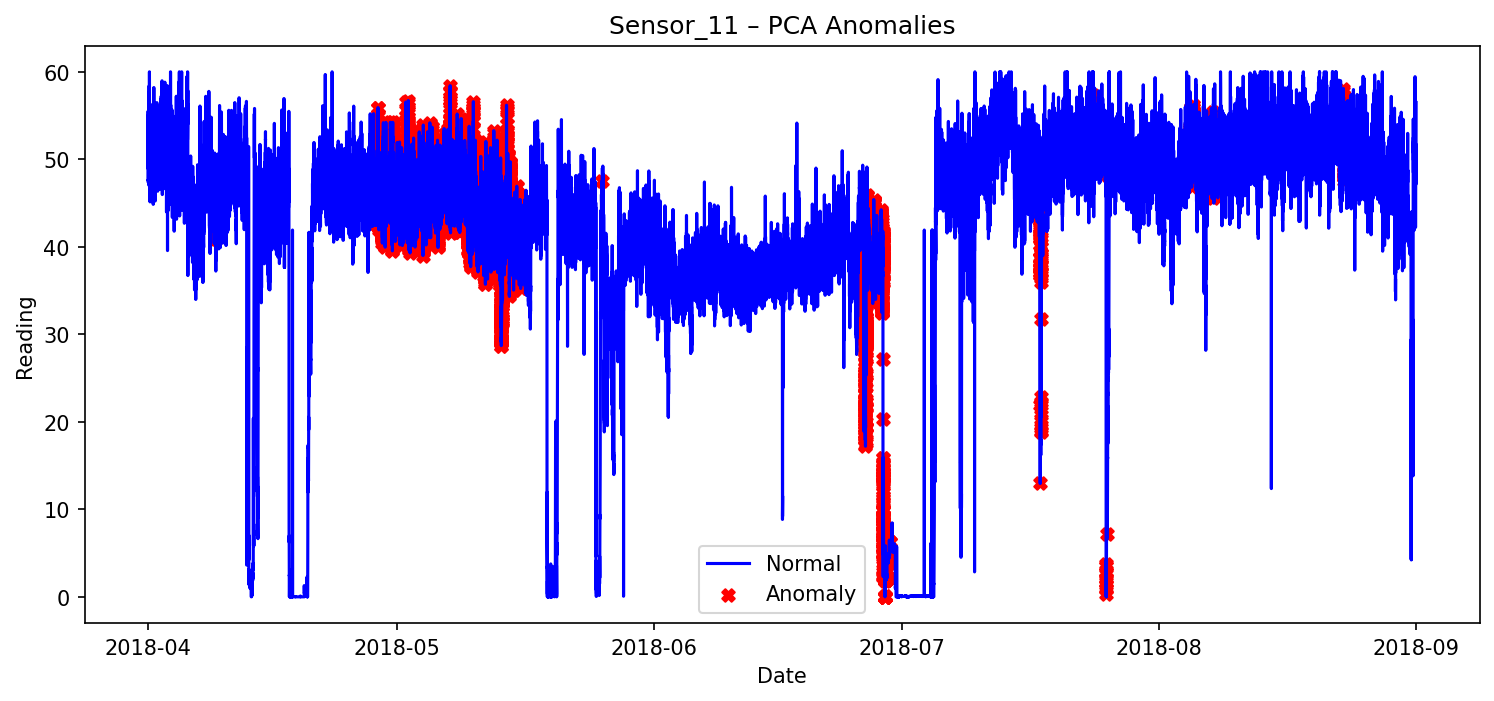

In [23]:
anom = df[df['anomaly_pc1']==1]
plt.figure(figsize=(12,5), dpi=150)
plt.plot(df['sensor_11'], label='Normal', color='blue')
plt.scatter(anom.index, anom['sensor_11'], color='red', marker='X', label='Anomaly')
plt.title('Sensor_11 – PCA Anomalies')
plt.xlabel('Date')
plt.ylabel('Reading')
plt.legend()
plt.show()


## 19. K-Means Clustering Anomaly Detection
Cluster the two PCs into 2 groups, visualize cluster sizes and scatter.

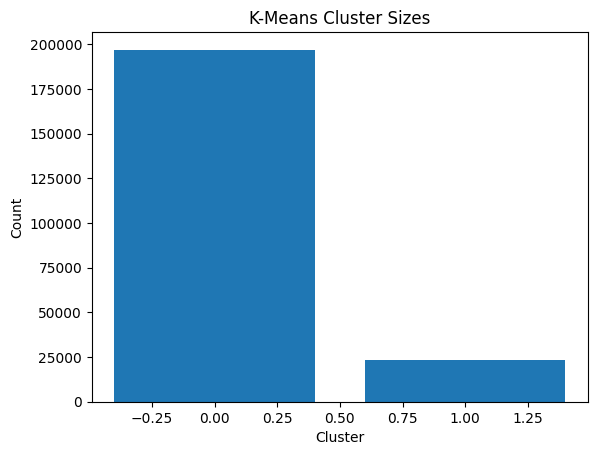

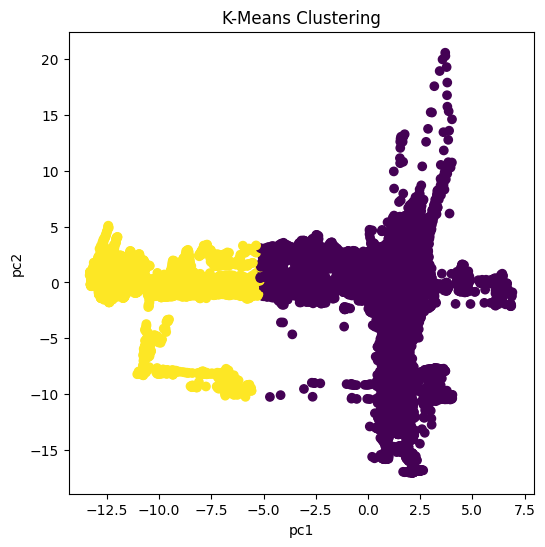

In [24]:
kmeans = KMeans(n_clusters=2, random_state=42).fit(pc_df)
labels = kmeans.labels_

# Cluster counts
counts = pd.Series(labels).value_counts()
plt.bar(counts.index, counts.values)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('K-Means Cluster Sizes')
plt.show()

# Scatter in PC space
plt.figure(figsize=(6,6))
plt.scatter(pc_df['pc1'], pc_df['pc2'], c=labels, cmap='viridis')
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.title('K-Means Clustering')
plt.show()


## 20. Distance-Based Anomalies (K-Means)
Compute each point’s distance to its centroid and flag the top 13% furthest as anomalies.

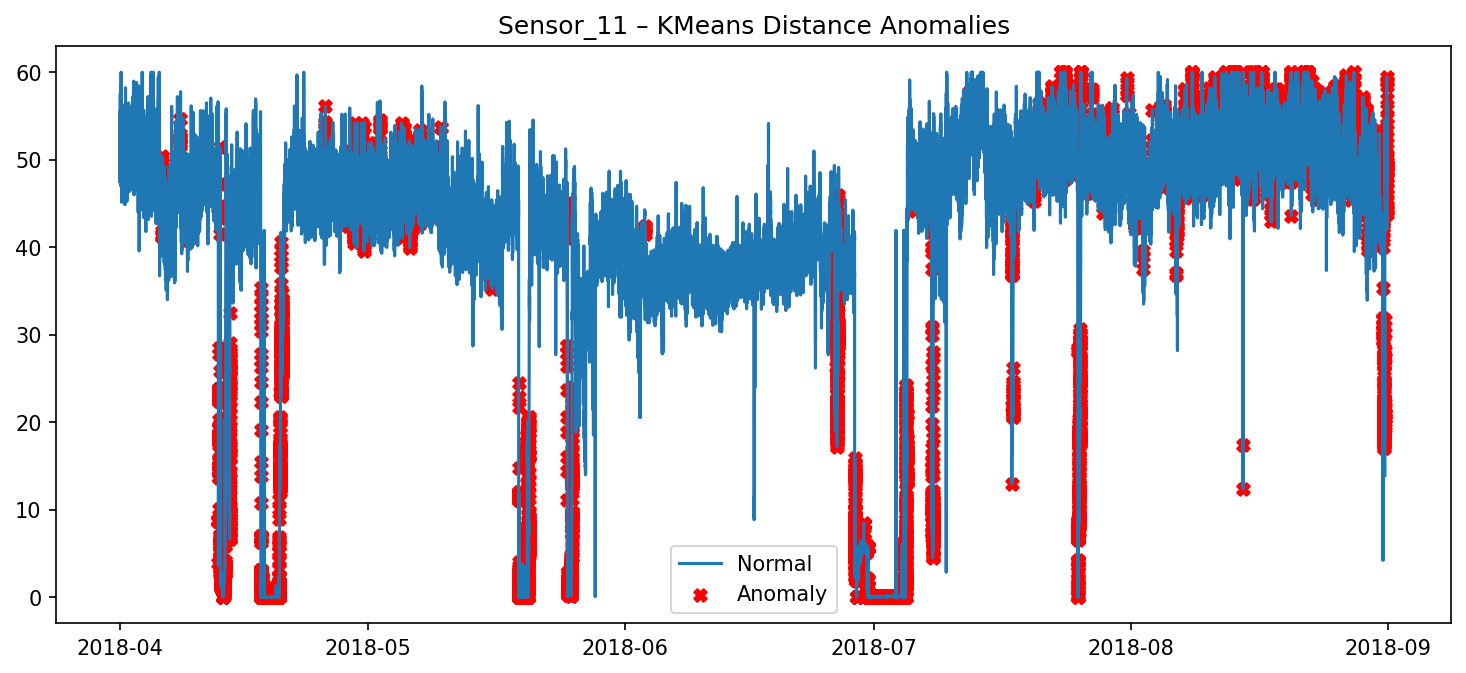

In [25]:
def get_distances(data, model):
    dists = []
    for i, xi in enumerate(data.values):
        center = model.cluster_centers_[model.labels_[i]]
        dists.append(np.linalg.norm(xi-center))
    return pd.Series(dists, index=data.index)

distances = get_distances(pc_df, kmeans)
n_out = int(0.13 * len(distances))
threshold = distances.nlargest(n_out).min()

pc_df['anomaly1'] = (distances >= threshold).astype(int)
df['anomaly1']    = pc_df['anomaly1']

# Plot on sensor_11
anom1 = df[df['anomaly1']==1]
plt.figure(figsize=(12,5), dpi=150)
plt.plot(df['sensor_11'], label='Normal')
plt.scatter(anom1.index, anom1['sensor_11'], color='red', marker='X', label='Anomaly')
plt.title('Sensor_11 – KMeans Distance Anomalies')
plt.legend()
plt.show()


## 21. Isolation Forest Anomaly Detection
Use an IsolationForest to flag ~13% of points as anomalies and visualize.

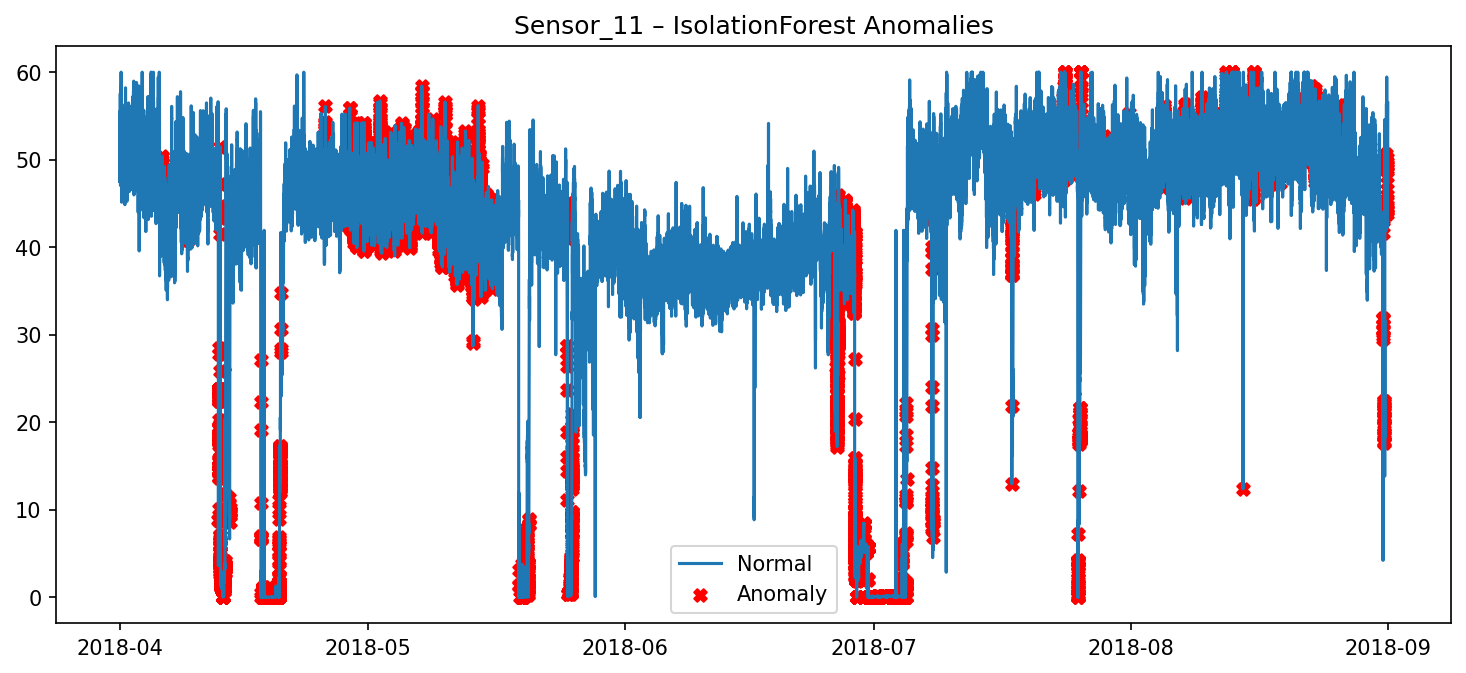

IsolationForest anomalies count: 28634


In [26]:
iso = IsolationForest(contamination=0.13, random_state=42).fit(pc_df[['pc1','pc2']])
pc_df['anomaly2'] = iso.predict(pc_df[['pc1','pc2']])
df['anomaly2']    = pc_df['anomaly2']

anom2 = df[df['anomaly2']==-1]
plt.figure(figsize=(12,5), dpi=150)
plt.plot(df['sensor_11'], label='Normal')
plt.scatter(anom2.index, anom2['sensor_11'], color='red', marker='X', label='Anomaly')
plt.title('Sensor_11 – IsolationForest Anomalies')
plt.legend()
plt.show()

print('IsolationForest anomalies count:', (df['anomaly2']==-1).sum())


## 22. Summary of Anomaly Counts
Print a small table summarizing counts from each method.

In [27]:
summary = pd.DataFrame({
    'Method': ['PCA IQR', 'KMeans Distance', 'IsolationForest'],
    'Anomalies': [df['anomaly_pc1'].sum(),
                  df['anomaly1'].sum(),
                  (df['anomaly2']==-1).sum()]
})
print(summary.to_string(index=False))


         Method  Anomalies
        PCA IQR      28476
KMeans Distance      28641
IsolationForest      28634


## 23. Classification: Preparing Data
Drop all anomaly flags and PCs, keep raw sensors as features, and machine_status as target.

In [28]:
features = df.drop(['machine_status','pc1','pc2',
                    'anomaly_pc1','anomaly_pc2',
                    'anomaly1','anomaly2'], axis=1)
target   = df['machine_status']
features.head()


sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  \
date                                                                         
2018-04-01 00:00:00   2.465394   47.09201    53.2118  46.310760   634.3750   
2018-04-01 00:01:00   2.465394   47.09201    53.2118  46.310760   634.3750   
2018-04-01 00:02:00   2.444734   47.35243    53.2118  46.397570   638.8889   
2018-04-01 00:03:00   2.460474   47.09201    53.1684  46.397568   628.1250   
2018-04-01 00:04:00   2.445718   47.13541    53.2118  46.397568   636.4583   

                     sensor_05  sensor_06  sensor_07  sensor_08  sensor_09  \
date                                                                         
2018-04-01 00:00:00   76.45975   13.41146   16.13136   15.56713   15.05353   
2018-04-01 00:01:00   76.45975   13.41146   16.13136   15.56713   15.05353   
2018-04-01 00:02:00   73.54598   13.32465   16.03733   15.61777   15.01013   
2018-04-01 00:03:00   76.98898   13.31742   16.24711   15.69734   15.08247   
2018-04-01 00:04:00   76.58897   13.35359   16.21094   15.69734   15.08247   

                     ...  sensor_41  sensor_42  sensor_43  sensor_44  \
date                 ...                                               
2018-04-01 00:00:00  ...   30.98958  31.770832   41.92708  39.641200   
2018-04-01 00:01:00  ...   30.98958  31.770832   41.92708  39.641200   
2018-04-01 00:02:00  ...   30.46875  31.770830   41.66666  39.351852   
2018-04-01 00:03:00  ...   30.46875  31.510420   40.88541  39.062500   
2018-04-01 00:04:00  ...   30.98958  31.510420   41.40625  38.773150   

                     sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  \
date                                                                         
2018-04-01 00:00:00   65.68287   50.92593  38.194440   157.9861   67.70834   
2018-04-01 00:01:00   65.68287   50.92593  38.194440   157.9861   67.70834   
2018-04-01 00:02:00   65.39352   51.21528  38.194443   155.9606   67.12963   
2018-04-01 00:03:00   64.81481   51.21528  38.194440   155.9606   66.84028   
2018-04-01 00:04:00   65.10416   51.79398  38.773150   158.2755   66.55093   

                     sensor_51  
date                            
2018-04-01 00:00:00   201.3889  
2018-04-01 00:01:00   201.3889  
2018-04-01 00:02:00   203.7037  
2018-04-01 00:03:00   203.1250  
2018-04-01 00:04:00   201.3889  

[5 rows x 50 columns]

## 24. Train/Test Split
Split into 70% train, 30% test with a fixed random seed.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42)


In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)




## 25. Helper Function for ML Algorithms
Define a function to fit any classifier and report training & test accuracy.

In [31]:
def fit_ml_algo(algo, X_train, y_train, X_test, y_test):
    """Train algo, return (train_acc%, test_acc%)."""
    model = algo.fit(X_train, y_train)
    return (round(model.score(X_train, y_train)*100,2),
            round(model.score(X_test,  y_test)*100, 2))


## 26. Evaluate Multiple Classifiers
Train and time Logistic Regression, KNN, SVM, Decision Tree, and Random Forest.

In [32]:
results = []
for name, algo in [
    ('Logistic Regression', LogisticRegression(solver='liblinear', max_iter=1000))
,
    ('KNN',                KNeighborsClassifier()),
    ('Linear SVC',         LinearSVC()),
    ('Decision Tree',      DecisionTreeClassifier()),
    ('Random Forest',      RandomForestClassifier())
]:
    start = time.time()
    tr, te = fit_ml_algo(algo, X_train_scaled, y_train, X_test_scaled, y_test)
    runtime = datetime.timedelta(seconds=time.time()-start)
    results.append({'Model':name,'Train %':tr,'Test %':te,'Time':runtime})

results_df = pd.DataFrame(results).sort_values('Test %', ascending=False)
print(results_df.to_string(index=False))


              Model  Train %  Test %                   Time
                KNN    99.99   99.99 0 days 00:00:31.549231
      Random Forest   100.00   99.99 0 days 00:00:51.352999
      Decision Tree   100.00   99.95 0 days 00:00:04.835140
Logistic Regression    99.80   99.79 0 days 00:00:06.292878
         Linear SVC    99.77   99.77 0 days 00:00:02.067488


## 27. Final Random Forest & Confusion Matrix
Retrain Random Forest, predict on test set, and visualize performance.

Test accuracy: 99.99%


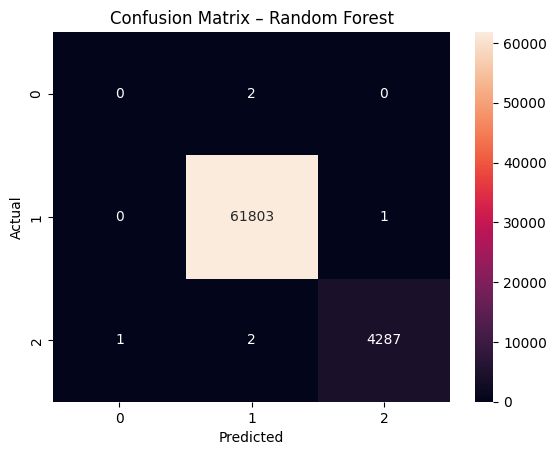

date
2018-06-15 02:25:00    NORMAL
2018-08-08 00:59:00    NORMAL
2018-07-14 14:48:00    NORMAL
2018-08-29 14:38:00    NORMAL
2018-08-17 18:13:00    NORMAL
Name: machine_status, dtype: object

In [37]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

print(f'Test accuracy: {clf.score(X_test, y_test)*100:.2f}%')

# Confusion matrix
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix – Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Show true labels for reference
y_test.head()


# FINAL MODEL EXTRACTION USING .pkl

In [38]:
import joblib

# assume `clf` is your trained RandomForestClassifier
joblib.dump(clf, 'rf_model.pkl')
print("Model saved to rf_model.pkl")


Model saved to rf_model.pkl


## Predicting Pump Failure on New Data

1. **Load your trained model** (we assume you’ve already serialized it to `rf_model.pkl`).  
2. **Read in** the new dataset of sensor readings (no labels needed).  
3. **Select the same feature columns** you trained on.  
4. **Run** `clf.predict(...)` to get “BROKEN”/“NORMAL”.  
5. **Inspect** and **save** the results.


In [40]:
# 1. Load the trained Random Forest
clf = joblib.load('rf_model.pkl')

# 2. Read the new sensor dataset
#    (must have exactly the same sensor columns you used in training)
new_df = pd.read_csv('sensor.csv')

# 3. Select feature columns in the order the model expects
#    If you used `clf.feature_names_in_` when saving, we can re-use that:
feature_cols = list(clf.feature_names_in_)

X_new = new_df[feature_cols]

# 4. Predict pump status
new_df['predicted_status'] = clf.predict(X_new)

# 5a. Quick look at the first few predictions
print(new_df[['predicted_status']].head())

# 5b. Summary counts
print(new_df['predicted_status'].value_counts())

# 5c. Save full results (including all original sensors + prediction)
new_df.to_csv('pump_failure_predictions.csv', index=False)
print("Results written to pump_failure_predictions.csv")

  predicted_status
0           NORMAL
1           NORMAL
2           NORMAL
3           NORMAL
4           NORMAL
predicted_status
NORMAL        205844
RECOVERING     14469
BROKEN             7
Name: count, dtype: int64
Results written to pump_failure_predictions.csv
